In [274]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from abc import ABC, abstractclassmethod
from EOF import EOF
from scipy.fftpack import fft,ifft,fftfreq
import datetime 

In [275]:
file  = "HSt42_10/RH80_PR10_1000day_startfrom_0day_final.dat"
ds = h5py.File(file, "r")
print(ds.keys())
# dycore = Dycore(file)
# u = dycore.getVar("grid_u_c_xyzt")
# # print(u.shape)

<KeysViewHDF5 ['_types', 'convection_xyzt', 'factor1_xyzt', 'factor2_xyzt', 'factor3_xyzt', 'factor4_xyzt', 'grid_div_xyzt', 'grid_geopots_xyzt', 'grid_p_full_xyzt', 'grid_p_half_xyzt', 'grid_ps_c_xyzt', 'grid_ps_p_xyzt', 'grid_t_c_xyzt', 'grid_t_n_xyzt', 'grid_t_p_xyzt', 'grid_tracers_c_xyzt', 'grid_tracers_diff_xyzt', 'grid_tracers_n_xyzt', 'grid_tracers_p_xyzt', 'grid_u_c_xyzt', 'grid_u_n_xyzt', 'grid_u_p_xyzt', 'grid_v_c_xyzt', 'grid_v_n_xyzt', 'grid_v_p_xyzt', 'grid_vor_xyzt', 'grid_z_full_xyzt', 'grid_δtracers_xyzt', 'grid_δu_xyzt', 'grid_δv_xyzt', 'spe_div_c_xyzt', 'spe_div_p_xyzt', 'spe_lnps_c_xyzt', 'spe_lnps_p_xyzt', 'spe_t_c_xyzt', 'spe_t_p_xyzt', 'spe_tracers_c_xyzt', 'spe_tracers_p_xyzt', 'spe_vor_c_xyzt', 'spe_vor_p_xyzt']>


In [276]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        self.Rd = 287
        self.cp = 1004
        self.g  = 9.81
        self.H  = 6800
        self.a  = 6.37122e6
        self.u  = self.getVar("grid_u_c_xyzt")
        self.u_p  = self.getVar("grid_u_p_xyzt")
        self.u_n  = self.getVar("grid_u_n_xyzt")
        
        
        self.v  = self.getVar("grid_v_c_xyzt")
        self.t  = self.getVar("grid_t_c_xyzt")
        self.ps = self.getVar("grid_ps_c_xyzt")
        self.p  = self.getVar("grid_p_full_xyzt")
        self.p_half  = self.getVar("grid_p_half_xyzt")

        self.qv   = self.getVar("grid_tracers_c_xyzt")
        self.qv_p = self.getVar("grid_tracers_p_xyzt")
        self.qv_n = self.getVar("grid_tracers_n_xyzt")
        
        
        self.qv_diff = self.getVar("grid_tracers_diff_xyzt")
        self.factor1 = self.getVar("factor1_xyzt")
        self.factor2 = self.getVar("factor2_xyzt")
        self.factor3 = self.getVar("factor3_xyzt")
        # self.factor4 = self.getVar("factor4_xyzt")


        self.convection = self.getVar("convection_xyzt")
        
        # self.theta = self.t * (self.ps / self.p)**(self.Rd/self.cp)
        
        # self.Uzm   = np.nanmean(self.u, axis=3)
        # self.Vzm   = np.nanmean(self.v, axis=3)
        # self.THzm  = np.nanmean(self.theta, axis=3)
        # self.Pzm   = np.nanmean(self.p, axis=3)
        # self.Tzm   = np.nanmean(self.t, axis=3)
        
        # ### anamoly
        # self.Vzmtm  = np.nanmean(self.Vzm, axis=0)
        # self.Uzmtm  = np.nanmean(self.Uzm, axis=0)
        # self.THzmtm = np.nanmean(self.THzm, axis=0)
        # self.Pzmtm  = np.nanmean(self.Pzm, axis=0)
        # self.Tzmtm  = np.nanmean(self.Tzm, axis=0)

        # self.Vza     = np.zeros(self.u.shape)
        # self.Uza     = np.zeros(self.u.shape)
        # self.THETAza = np.zeros(self.u.shape)
        # self.Pza     = np.zeros(self.u.shape)
        # self.Tza     = np.zeros(self.t.shape)

        # for i in range(0,128):
        #     self.Vza[:,:,:,i]     = self.v[:,:,:,i] - self.Vzm
        #     self.Uza[:,:,:,i]     = self.u[:,:,:,i] - self.Uzm
        #     self.THETAza[:,:,:,i] = self.theta[:,:,:,i] - self.THzm
        #     self.Pza[:,:,:,i]     = self.p[:,:,:,i] - self.Pzm
        #     self.Tza[:,:,:,i]     = self.t[:,:,:,i] - self.Tzm
        
        ### the variables for plot
        self.sigma_mean           = np.nanmean(self.p/self.ps, axis=(0,3))
        self.sigma_onlyz          = np.nanmean(self.sigma_mean, axis=1)
        self.y                    = np.linspace(-90,90,64)
        self.yy, self.sigma_mean2 = np.meshgrid(self.y,self.sigma_onlyz)
        
        ### cooridate
        self.x  = np.linspace(-180,180,128)
        self.y  = np.linspace(-90,90,64)
        self.xd = np.deg2rad(self.x)
        self.yd = np.deg2rad(self.y)
        # self.xx, self.yy = np.meshgrid(self.x,self.y)
        
        # WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
        self.cy     = np.cos(self.yd)
        self.cy[0]  = np.nan
        self.cy[-1] = np.nan

    def getVar(self, var):
        # self.u  = self.ds["grid_u_c_xyzt"]
        return np.asarray(self.ds[var])
    
    def cal_KE(self):
        self.KE = (self.u**2 + self.v**2)
        self.KE_mean = np.nanmean(self.KE, axis=(1,3))
        return self.KE_mean
    
    def cal_pre(self):
        self.Prec = np.zeros(self.u.shape)
        for i in range(1,20-1):
            self.Prec[:,i,:,:] = 1/self.g * self.qv_diff[:,i,:,:] * (self.p_half[:,i+1,:,:] - self.p_half[:,i,:,:])
        self.Prec[:, 0,:,:] = 1/self.g * self.qv_diff[:, 0,:,:] * (self.p_half[:, 1,:,:] - self.p_half[:, 0,:,:])
        # self.Prec[:,-1,:,:] = 1/self.g * self.qv[:,-1,:,:] * (self.p_half[:,-1,:,:] - self.p_half[:,-2,:,:])
        
        self.Prec_mean = np.nansum(self.Prec, axis=(1))
        self.Prec_mean2 = np.nanmean(self.Prec_mean, axis=(2))
        
        return self.Prec_mean2
    
    def cal_t(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[:,:,:,:], axis=(1,3))
        return self.t_mean
    
    def cal_t_last(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[-100:,:,:,:], axis=(1,3))
        return self.t_mean
    
    def cal_diff(self):
        
        return np.nanmean(self.factor3, axis=(1,3))

In [277]:
def read_all_var(pr, start, end, internal_day, total_file):
    qv_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    qv_diff_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    u_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    v_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    t_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    p_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    ps_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    
    p_half_all = np.zeros(((total_file, 100, 21 , 64, 128)))
    a = 0
    for day in range(start,end,internal_day):
        # print(day)
        file  = f"HSt42_{pr}/RH80_PR{pr}_1000day_startfrom_{day}day_final.dat"
        dycore = Dycore(file)
        
     #   Prec[a,:,:]    = dycore.cal_pre()
        
        qv_all[a,:,:,:,:]   = dycore.qv
        qv_diff_all[a,:,:,:,:]   = dycore.qv_diff
        u_all[a,:,:,:,:]    = dycore.u
        v_all[a,:,:,:,:]    = dycore.v
        t_all[a,:,:,:,:]    = dycore.t
        p_all[a,:,:,:,:]    = dycore.p
        ps_all[a,:,:,:,:]    = dycore.ps
        
        p_half_all[a,:,:,:,:]    = dycore.p_half
        a += 1
        # print(a)
    # qv_all_new      = np.nanmean(qv_all  , axis=0)
    # qv_diff_new      = np.nanmean(qv_diff_all  , axis=0)
    # u_new      = np.nanmean(u_all  , axis=0)
    # v_new      = np.nanmean(v_all  , axis=0)
    # t_new      = np.nanmean(t_all  , axis=0)
    # p_new      = np.nanmean(p_all  , axis=0)
    # p_half_new      = np.nanmean(p_half_all  , axis=0)
    


    # qv = qv_all
    # qv_diff = qv_diff_new
    # u = u_new
    # v = v_new
    # t = t_new
    # p = p_new
    # p_half = p_half_new
    return qv_all, qv_diff_all, u_all, v_all, t_all, p_all, ps_all, p_half_all

In [278]:
def cal_pre(qv_diff, p_half):
    g = 9.81
    Prec = np.zeros(qv_diff.shape)
    for i in range(1,20-1):
        Prec[:,i,:,:] = 1/g * qv_diff[:,i,:,:] * (p_half[:,i+1,:,:] - p_half[:,i,:,:])
    Prec[:, 0,:,:] = 1/g * qv_diff[:, 0,:,:] * (p_half[:, 1,:,:] - p_half[:, 0,:,:])
    # self.Prec[:,-1,:,:] = 1/self.g * self.qv[:,-1,:,:] * (self.p_half[:,-1,:,:] - self.p_half[:,-2,:,:])
    
    Prec_mean = np.nansum(Prec, axis=(1))
    Prec_mean2 = np.nanmean(Prec_mean, axis=(2))
    
    return Prec_mean2

In [279]:
def cal_KE(u, v):
    KE = (u**2 + v**2)
    KE_mean = np.nanmean(KE, axis=(1,3))
    return KE_mean

1000


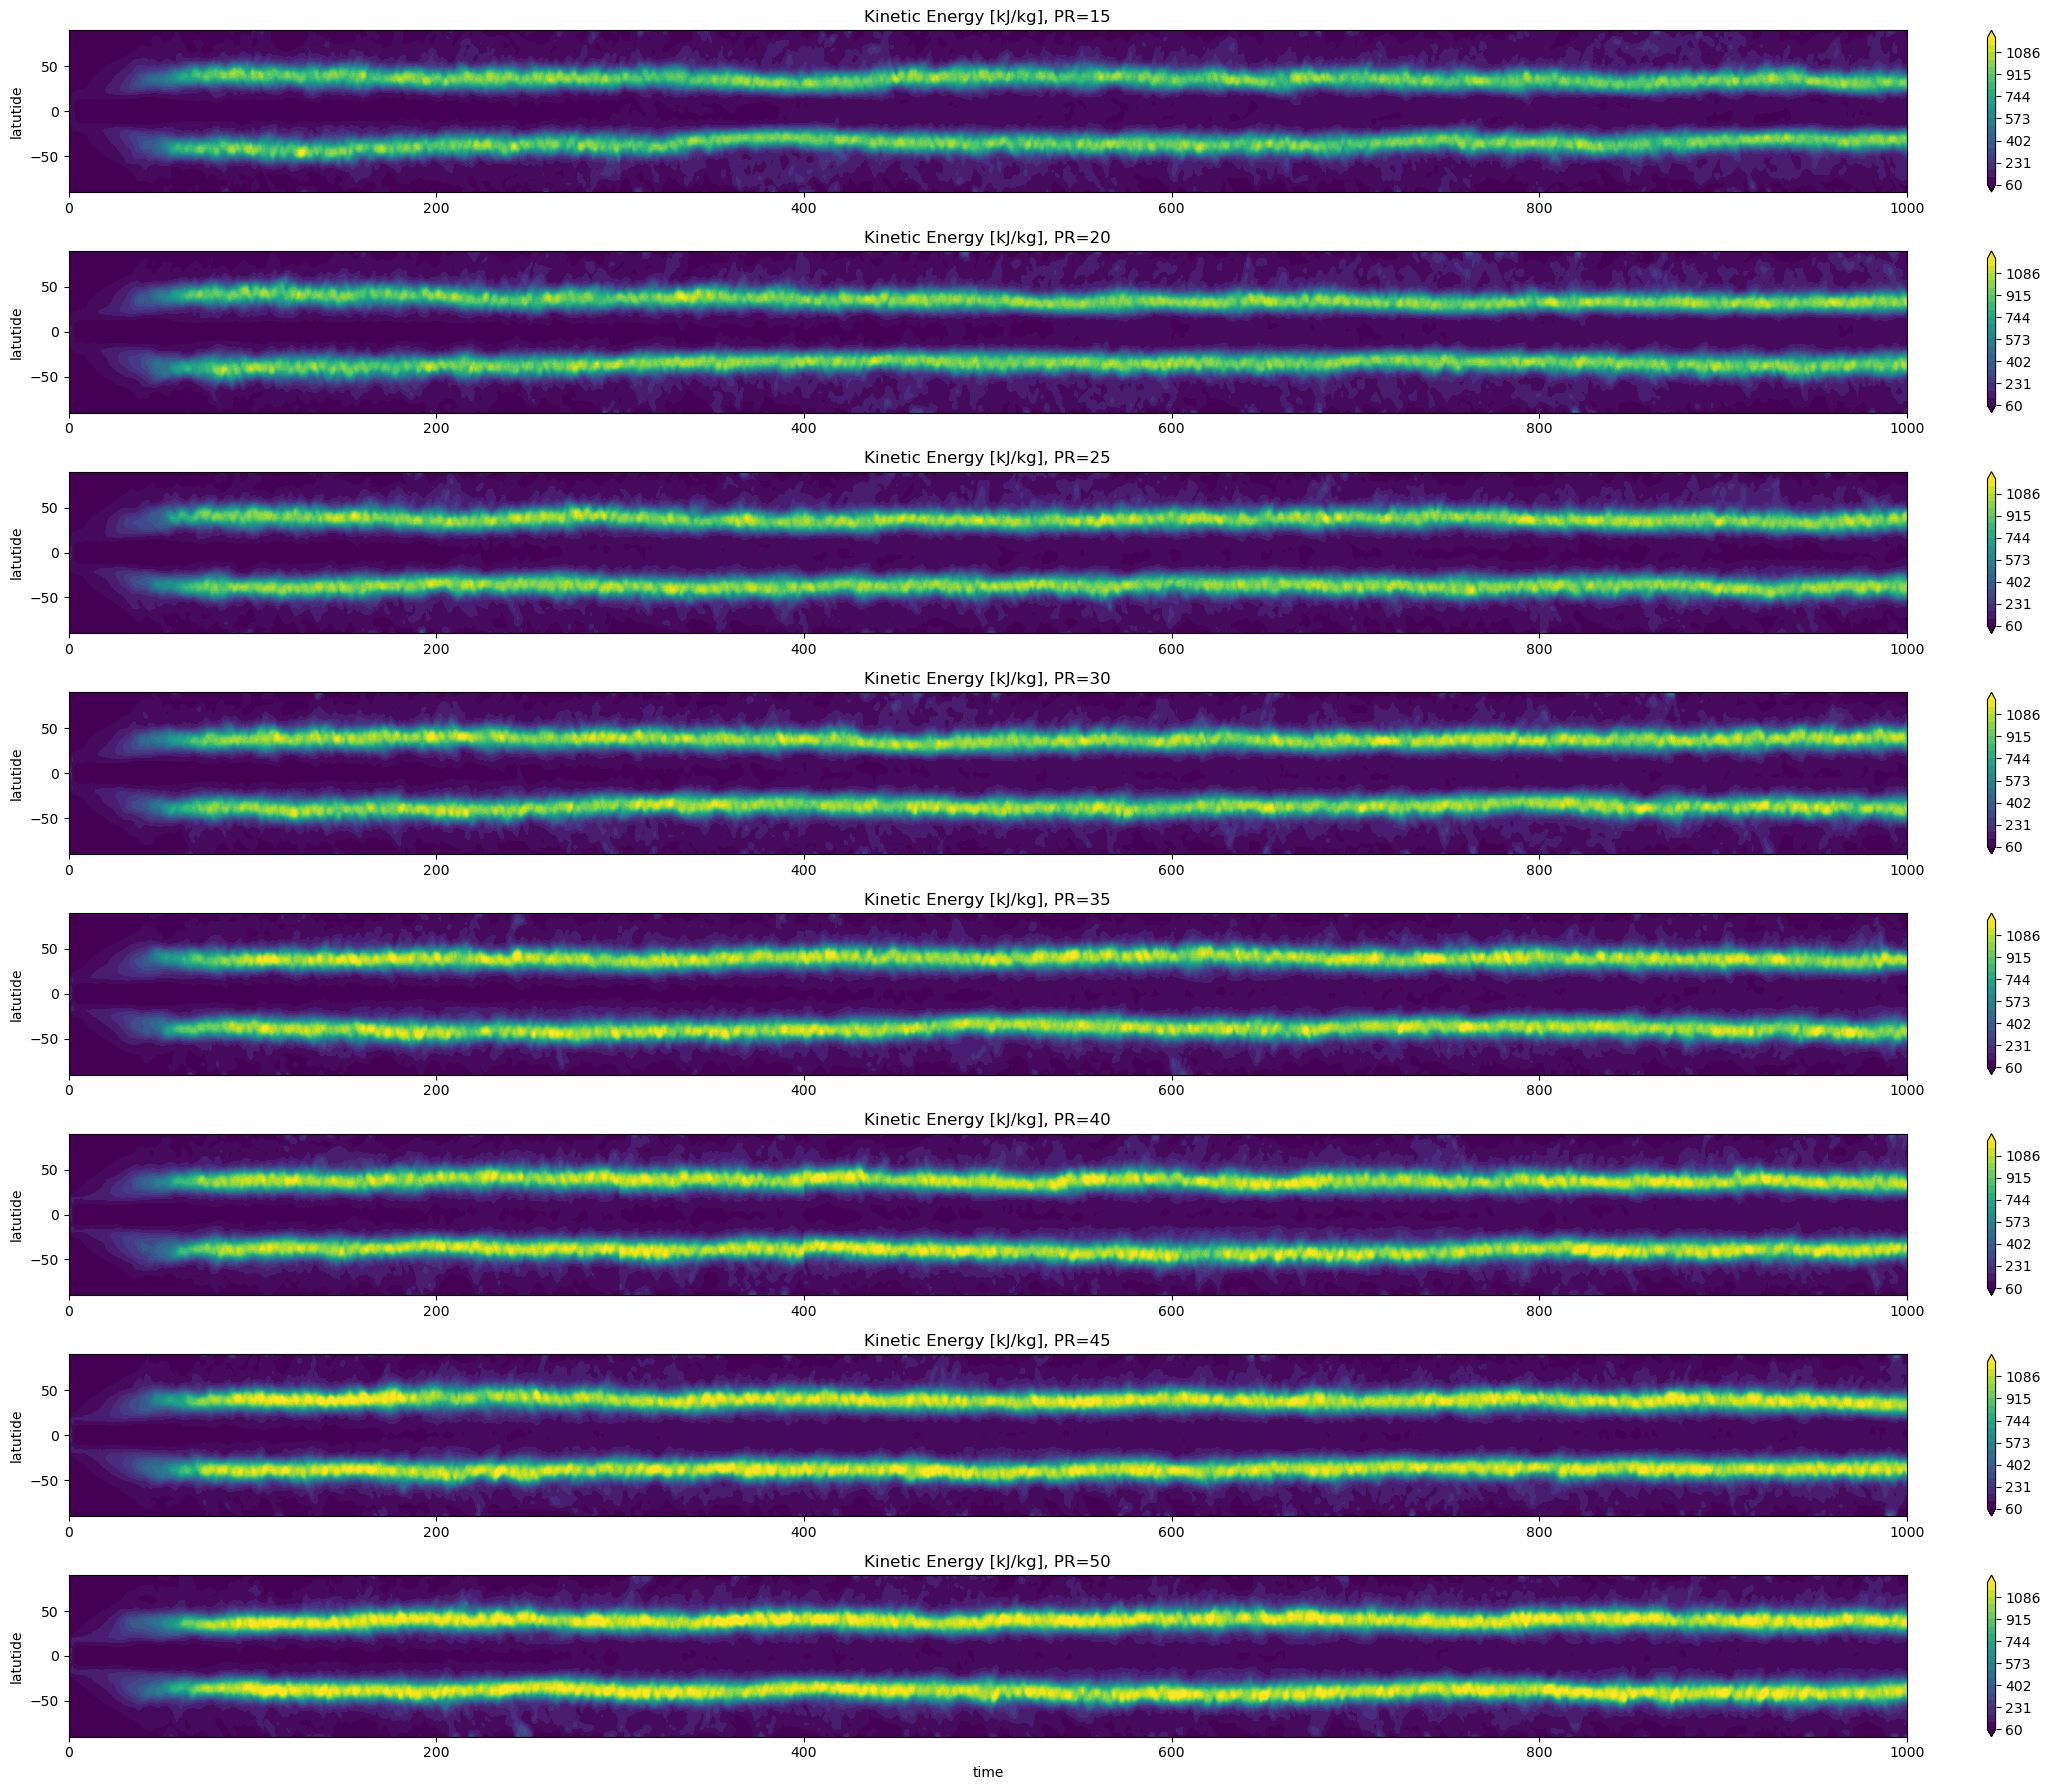

In [283]:
pr_start = 15
pr_leap = 5
pr_to = 55
nProc = 2

start = 0
end   = 1000
internal_day = 100
total_file = int((end - start) / internal_day)
total_day = int(total_file*internal_day)
print(total_day)


qv = np.zeros((((total_day, 20, 64, 128))))
qv_diff = np.zeros((((total_day, 20, 64, 128))))
u = np.zeros((((total_day, 20, 64, 128))))
v = np.zeros((((total_day, 20, 64, 128))))
t = np.zeros((((total_day, 20, 64, 128))))
p = np.zeros((((total_day, 20, 64, 128))))
ps = np.zeros((((total_day, 20, 64, 128))))
p_half = np.zeros((((total_day, 21, 64, 128))))

### fig
y = np.linspace(-90,90,64)
time = np.linspace(start, end, total_day)
yy, tt = np.meshgrid(y,time)
a      = int(0)
fig,ax   = plt.subplots(int((pr_to - pr_start)/pr_leap),figsize=(21,18))
#########

do_check_qv = False
do_check_KE = True
do_check_t  = False
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if do_check_qv:
            if k ==0:
                qv[0:100,:,:,:]      = qv_ini[k,:,:,:,:]
                qv_diff[0:100,:,:,:] = qv_diff_ini[k,:,:,:,:]
                p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
                ps[0:100,:,:,:]             = ps_ini[k,:,:,:,:]
                p_half[0:100,:,:,:]        = p_half_ini[k,:,:,:,:]            
            else:
                qv[k*100:(k+1)*100,:,:,:] = qv_ini[k,:,:,:,:]
                qv_diff[k*100:(k+1)*100,:,:,:] = qv_diff_ini[k,:,:,:,:]
                p[k*100:(k+1)*100,:,:,:] = p_ini[k,:,:,:,:]
                ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
                p_half[k*100:(k+1)*100,:,:,:] = p_half_ini[k,:,:,:,:]
                
        if do_check_KE:
            if k ==0:
                u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
                v[0:100,:,:,:]             = v_ini[k,:,:,:,:]
                p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
                ps[0:100,:,:,:]             = ps_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
                v[k*100:(k+1)*100,:,:,:] = v_ini[k,:,:,:,:]
                p[k*100:(k+1)*100,:,:,:] = p_ini[k,:,:,:,:]
                ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
                
        if do_check_t:
            if k ==0:
                t[0:100,:,:,:]             = t_ini[k,:,:,:,:]
            else:
                t[k*100:(k+1)*100,:,:,:] = t_ini[k,:,:,:,:]
                
                

    if do_check_qv:
        Prec_new   = cal_pre(qv_diff, p_half)
        CS = ax[a].contourf(tt, yy, Prec_new[:,:] * 86400,levels=np.linspace(0,10,21), extend="max")    
        fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
        ax[a].set_title(f"PR={pr},Precipitation [mm/day], RH=80%")    
        ax[a].set_xlabel("time")
        ax[a].set_ylabel("latutide")
        a += 1
    if do_check_KE:
        get_KE = cal_KE(u, v)   
        CS = ax[a].contourf(tt, yy, get_KE,levels=np.linspace(60,1200,21), extend="both")
        fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
        ax[a].set_title(f"Kinetic Energy [kJ/kg], PR={pr}")
        ax[-1].set_xlabel("time")
        ax[a].set_ylabel("latutide")
        a += 1
    if do_check_t:
        t_mean = np.nanmean(t[:,:,:,:], axis=(1,3))
        CS = ax[a].contourf(tt, yy, t_mean,levels=21, extend="both")
        fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
        ax[a].set_title(f"Temperature [K], PR={pr}")
        ax[-1].set_xlabel("time")
        ax[a].set_ylabel("latutide")
        a += 1
        
        
if do_check_qv:
    fig.tight_layout()
    # plt.savefig("check_qv_equilibrium.png", dpi=300., bbox_inches='tight')
    plt.show()
if do_check_KE:
    fig.tight_layout()
    # plt.savefig("check_KE_equilibrium.png", dpi=300., bbox_inches='tight')
    plt.show()
if do_check_t:
    fig.tight_layout()
    # plt.savefig("check_T_equilibrium.png", dpi=300., bbox_inches='tight')
    plt.show()

    #     print(result.shape)
    #     print(result)
    # EMF_80[a,:] = EMF_results[32:]
    # EQF_80[a,:] = EQF_results[32:]
    # EHF_80[a,:] = EHF_results[32:]
    # EKF_80[a,:] = EKF_results[32:]
    # prec_80[a,:]  = prec_results[:] #* float(t)

# Calculate EOF of u, then plot y-z 

In [ ]:
from EOF import EOF

In [ ]:
y  = np.linspace(-90,90,64)
yd = np.deg2rad(y)
cy = np.cos(yd)
# cy [0] = np.nan
# cy [-1] = np.nan
cy

In [ ]:
pr_start = 0
pr_leap = 5
pr_to = 40
nProc = 2


### fig
yy, tt = np.meshgrid(y,time)
a      = int(0)
fig,ax   = plt.subplots(int((pr_to - pr_start)/pr_leap),figsize=(6,24), dpi=300.)
print(int((pr_to - pr_start)/pr_leap))
#########

start = 200
end   = 1000
internal_day = 100
total_file = int((end - start) / internal_day)
# print(total_file)
total_day = int(total_file*internal_day)


u = np.zeros((((total_day, 20, 64, 128))))


do_check_u_EOF = True
check_days_length = int(800)

sigma_mean      = np.nanmean(p[-check_days_length:,:,:,:]/ps[-check_days_length:,:,:,:], axis=(0,3))
sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
y               = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)

a = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if do_check_u_EOF:
            if k ==0:
                u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
          
            else:
                u[k*100:(k+1)*100,:,:,:]   = u_ini[k,:,:,:,:]

    # Step 1: weight and time, zonal mean
    u_w = np.zeros((((check_days_length, 20, 64, 128))))
    for i in range(0,64):
        u_w[:,:,i,:] = u[-check_days_length:,:,i,:] #* (cy[i])**0.5
    u_w_zy = np.nanmean(u_w[:,:,:,:], axis=(3))
    u_w_zy_reshape = np.reshape(u_w_zy, (check_days_length, 20*64))
    print(u_w_zy_reshape.shape)
    # Step 2: do EOF of u
    single_EOF = EOF((u_w_zy_reshape,), n_components=check_days_length, field="1D")
    single_EOF.get()
    # Step 3: PC / PC_std and EOF * PC_std
    PCs   = single_EOF.PC[0,:]
    EOFs  = single_EOF.EOF[0,:]
    
    PCs_std = PCs.std()
    PCs     = PCs / PCs_std
    
    EOFs_std  = EOFs.std()
    EOFs      = EOFs * PCs_std
    # Step 4: reshape (1280,) back to (20,64)
    EOFs_zy = np.reshape(EOFs, (20,64))

    # Step 5: plot
    CS = ax[a].contourf(yy, sigma_mean2, EOFs_zy, levels=21, cmap="bwr", extend="both")
    fig.colorbar(CS, ax=ax[a], extend="both")
    ax[a].set_ylim([1,0])
    ax[a].set_title(f"PR{pr} EOF [u]", fontsize=14)
    ax[a].set_ylabel("sigma")
    ax[-1].set_xlabel("latitude")
    a += 1
fig.tight_layout()
plt.savefig("check_U_EOF.png", dpi=300., bbox_inches='tight')
plt.show()
    # if do_check_u_EOF:
    #     Prec_new   = cal_pre(qv_diff, p_half)
    #     CS = ax[a].contourf(tt, yy, Prec_new[:,:] * 86400,levels=np.linspace(0,10,21), extend="max")    
    #     fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
    #     ax[a].set_title(f"PR={pr},Precipitation [mm/day], RH=80%")    
    #     ax[a].set_xlabel("time")
    #     ax[a].set_ylabel("latutide")
    #     a += 1

In [ ]:
plt.figure()
plt.plot(PCs)
# plt.ylim([1,0])
plt.title("PC [u]", fontsize=14)
# plt.ylabel("sigma")
plt.xlabel("Day")

In [ ]:
plt.figure()
EOFs_final = np.reshape(EOFs, (20,64))
plt.plot(EOFs_final[10,:])
# plt.ylim([1,0])
plt.title("EOF [u] level 10th", fontsize=14)
# plt.ylabel("sigma")
plt.xlabel("Day")

In [ ]:
plt.figure()
CS = plt.contourf(yy, sigma_mean2, u_w_zy.mean(axis=0), levels=21)
plt.colorbar(CS)
plt.ylim([1,0])
plt.title("original u")

In [ ]:
print(np.shape((single_EOF.EOF.T.dot(single_EOF.PC)).T))
test = np.reshape((single_EOF.EOF.T.dot(single_EOF.PC)).T, (check_days_length, 20*64))
test_mean = np.nanmean(test, axis=0)
test_final = np.reshape(test_mean, (20,64))
plt.figure()
CS = plt.contourf(test_final, levels=21)
plt.colorbar(CS)
plt.ylim([20,0])
plt.title("test from EOF and PC back to u")

# plot original u different PR

In [ ]:
pr_start = 0
pr_leap = 5
pr_to = 40

do_check_u = True
fig,ax   = plt.subplots(8,figsize=(5,24), dpi=300.)
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if do_check_u:
            if k ==0:
                u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
    if do_check_u:
        u_mean = np.nanmean(u, axis=(0,3))
        CS = ax[a].contourf(yy, sigma_mean2, u_mean,levels=np.linspace(-18,36,21), extend="both")
        fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
        ax[a].set_ylim([1,0])
        ax[a].set_title(f"u wind [m/s], PR={pr}")
        ax[-1].set_xlabel("time")
        ax[a].set_ylabel("latutide")
        a += 1
if do_check_u:
    # plt.savefig("check_U_equilibrium.png", dpi=600., bbox_inches='tight')
    fig.tight_layout()
    plt.show()



# Plot different PR latitude profile u

In [ ]:
cy

In [ ]:
import matplotlib.colors as colors
import matplotlib as mpl
from scipy.interpolate import RectBivariateSpline

pr_start = 0
pr_leap = 5
pr_to = 40

fig, ax = plt.subplots(3, 2, figsize=(10, 9), dpi=300.)
y = np.linspace(-90, 90, 64)
###
### for color
rgb=([112,115,115])
rgb=np.array(rgb)/255.0
icmap=colors.ListedColormap(rgb,name='my_color')
cmap=mpl.cm.viridis

cmap_color=icmap  
# bound=[1E-4,10E-4,25E-4,50e-4,100E-4,150E-4,200E-4,250e-4]
colors = np.array([[112,115,115],[182,203,227],[89,159,218],[0,83,170],[0,4,167],[0,140,1]])/255
########

do_check_north_jet = True
do_check_south_jet = False
do_check_biggest_n_U = True

pr_file = int((pr_to - pr_start) / pr_leap)
a = 0
pr_north_idx_z = []
pr_north_idx_y = []

# Find the biggest n u wind
n = 20
biggest_n_U_z = np.zeros((pr_file, n)) 
biggest_n_U_y = np.zeros((pr_file, n))
interpolation_times = 10

for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if do_check_u:
            if k ==0:
                u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
    
    if do_check_north_jet:
        u_north_half = np.zeros((((u.shape[0],20,32,128))))
        for i in range(32):
            u_north_half[:,:,i,:] = u[:,:,i+32,:] * cy[i+32]**0.5
        u_zy = np.nanmean(u_north_half, axis=(0,3))
        idx_max = np.argmax(u_zy)
        k, j = np.unravel_index(idx_max, u_zy.shape) # which mean maximum z: kth index,
                                                     #            maxumum y: jth index
        pr_north_idx_y.append(j)
        pr_north_idx_z.append(k)
        # pr_idx_z_y[a,1] = j

        """
        # Becasue the grid is too coarse to identify the location of biggest u wind,
        # it would calculate the index of the biggest five u wind in the below code block.
        """
        if do_check_biggest_n_U:
            # Step 1. Do interpolation, increasing resolution third times
            interp_spline = RectBivariateSpline(sigma_onlyz, y[32:], u_zy)
            yys          = np.linspace(0, 90, 32*interpolation_times)
            sigma_mean2s = np.linspace(0,  1, 20*interpolation_times)
            
            Y, Z = np.meshgrid(yys, sigma_mean2s)
            
            u_zy_thin = interp_spline(sigma_mean2s, yys)
            # Step 2. Find the biggest n U wind
            small_idx = np.dstack(np.unravel_index(np.argsort(u_zy_thin.ravel()), (np.shape(sigma_mean2s)[0], np.shape(yys)[0]))) # (1, 20*32, 2)
            biggest_n_U_z[a,:] = small_idx[0,-n:,0]
            biggest_n_U_y[a,:] = small_idx[0,-n:,1]
            
        ############################################################################
        ### plot ###
        if pr == 0:
            print("Northern Hemisphere")
            control = np.nanmax(u_zy[k,:])
            ax[0,0].axvline(x=y[32+j], color='gray', lw=0.8)
            ax[0,0].axhline(y=0, color='gray', lw=0.8)
        print("PR:",pr,",maximum [z index, y index]:", k,j)
        
        ax[0,0].plot(y[32:], u_zy[k,:] / control, label=f"L = {pr/100}") #, color=colors[int(pr/5)]
        ax[0,0].set_title("Northern Hemisphere U", fontsize=8)
        ax[0,0].set_xlabel("latutide")
        
    if do_check_south_jet:
        u_south_half = np.zeros((((u.shape[0],20,32,128))))
        for i in range(32):
            u_south_half[:,:,i,:] = u[:,:,i,:] * cy[i]**0.5
        u_zy = np.nanmean(u_south_half, axis=(0,3))
        idx_max = np.argmax(u_zy)
        k, j = np.unravel_index(idx_max, u_zy.shape) # which mean maximum z: kth index,
                                                     #            maxumum y: jth index
        if pr == 0:
            print("Southern Hemisphere")
            control = np.nanmax(u_zy[k,:])
            ax[0,0].axvline(x=y[j], color='gray', lw=0.8)
            ax[0,0].axhline(y=0, color='gray', lw=0.8)
        print("PR:",pr,",maximum [z index, y index]:", k,j)
        
        ax[0,0].plot(y[:32], u_zy[k,:] / control, label=f"L = {pr/100}") #, color=colors[int(pr/5)]
        ax[0,0].set_title("Southern Hemisphere U", fontsize=8)
        ax[0,0].set_xlabel("latutide")

    a += 1
# plt.legend()
ax[0,0].legend(prop={'size': 8})
plt.show()

In [ ]:
print(biggest_n_U_z[0,:])
print(biggest_n_U_y[0,:])

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(10, 9), dpi=300.)
ax = ax.ravel()
a = 0
# b = 0
y_north = np.linspace(0,90,32*interpolation_times) 
z_north = np.linspace(0, 1,20*interpolation_times) 

for pr in range(pr_start, pr_to, pr_leap):
# for pr in range(0, 10, 5):
    for i in range(n):
        if i == int(n-1):
            ax[a].scatter(y_north[int(biggest_n_U_y[a,i])], z_north[int(biggest_n_U_z[a,i])], label=f"PR={pr}")
        else:
            ax[a].scatter(y_north[int(biggest_n_U_y[a,i])], z_north[int(biggest_n_U_z[a,i])])
            
    ax[a].set_title(f"NH PR={pr} "+f"index of the biggest {n} U wind")
    ax[a].set_ylim([0.26,0.20])
    ax[a].set_xlim([34,41])
    ax[a].set_ylabel("sigma")
    ax[a].set_xlabel("latitude")
    ax[a].legend()
    ax[a].grid()
    a += 1
plt.suptitle(f"Interpolate the resolution to {interpolation_times} times")

fig.tight_layout()

# plt.savefig("check_U_index.png", dpi=300., bbox_inches='tight')
plt.show()


In [ ]:
biggest_n_U_y[0,:]

In [ ]:
plt.figure()
a = 0
for pr in range(pr_start, pr_to, pr_leap):
# for pr in range(0, 10, 5):
    # print(pr)
    plt.scatter(y_north[int(np.nanmean(biggest_n_U_y[a,:]))], z_north[int(np.nanmean(biggest_n_U_z[a,:]))], label=f"PR={pr}")
    a+=1
plt.ylim([0.245,0.215])
plt.legend()
plt.title(f"Mean index of the biggest {n} U wind,"+f"interpolational times = {interpolation_times}") 
plt.grid()
# plt.savefig("check_mean_U_index.png", dpi=300., bbox_inches='tight')
plt.show()

# Interplotation

In [ ]:
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline

In [ ]:
sigma_onlyz

In [ ]:
y[32:]

In [ ]:
u_zy.shape

In [ ]:
interp_spline = RectBivariateSpline(sigma_onlyz, y[32:], u_zy)
yys          = np.linspace(0,90,64)
sigma_mean2s = np.linspace(0,1,40)

Y, Z = np.meshgrid(yys, sigma_mean2s)

u_zy_thin = interp_spline(sigma_mean2s, yys)
# for i in range(yys.shape[0]):
#     zs[i]=f(yys[i],sigma_mean2s[i])

In [ ]:
u_zy_thin.shape

In [ ]:
plt.figure()
plt.contourf(yy[:,32:], sigma_mean2[:,32:], u_zy)
plt.title("Original: (y,z) = (32,20)")
plt.ylim([1,0])

plt.figure()
plt.title("Interpolation: (y,z) = (64,40)")
plt.contourf(Y, Z, u_zy_thin)
plt.ylim([1,0])

# Calculate error bar of the interpolation

In [196]:
import random
import scipy.stats as st 

In [197]:
# Null hypothesis: To test the location of maximum u wind in 80 days would be different significantly.
# 
# I have (time, z, y, x) = (800, 20, 32, 128) in each hemisphere.
# Step 1. Interpolate from (80, 20, 32) => (80, 200, 320)
# Step 2. Randomly select the index of the day of 80 days from 200-1000 day 
#         => the reason why choose 80 not 20 or 10, because it takes 25 days to do Fourier transform in Lorenz paper, and 70~80 days to do the low frequency in Nick paper.
# Step 3. From (80, 200, 320) find the each day find the biggest 10% u wind of these 80 days of y-z coordinate,
#         that is 200 * 320 * 10% = 640 indexes. (Want to circle the biggest u wind on the y-z coordinate)
# Step 4. Do mean these 640 indexes => get the single point (y,z)
# Step 5. Repeat step 2-4 1000 times => get 1000 point (y,z)
# Step 6. plot mean and confident interval

In [198]:
def bootstrap_y(all_index, total_times, each_time, n, intepolation, y , sigma_onlyz, yys, sigma_mean2s):
    sample_idx_mean = []
    CI_low          = []
    CI_high         = []

    # biggest_n_U_z_errorbar_mean_all = np.zeros(np.shape(all_index)[0])# 640
    # biggest_n_U_y_errorbar_mean_all = np.zeros(np.shape(all_index)[0])

    biggest_n_U_z_errorbar_mean_final = np.zeros(total_times)
    biggest_n_U_y_errorbar_mean_final = np.zeros(total_times)
    selected_u_mean_total_time_y        = np.zeros(total_times)
    selected_u_mean_total_time_z        = np.zeros(total_times)
    
    #selected_u_mean_z = np.zeros(total_times)
    # Step 1. Interpolation 
    data_thin = np.zeros(((np.shape(all_index)[0], 20*intepolation, 32*intepolation)))
    
    biggest_n_U_z_errorbar = np.zeros(total_times)
    biggest_n_U_y_errorbar = np.zeros(total_times)
    # top_u_z                  = np.zeros(n)
    # top_u_y                  = np.zeros(n)

    for k in range(np.shape(all_index)[0]):
        interp_spline          = RectBivariateSpline(sigma_onlyz, y[32:], all_index[k,:,:])
        data_thin[k,:,:]       = interp_spline(sigma_mean2s, yys)


    for i in range(total_times): 
          # randomly select
          each_time_u   = np.zeros(((each_time, np.shape(data_thin)[1], np.shape(data_thin)[2])))  # randomly select each_time
          # each_time_z   = np.zeros(np.shape(all_index)[2])  # all_index  : (20, 32)each_time
          for j in range(each_time): # 80
              tmp_z  = np.zeros(int(20*32*intepolation*intepolation*n))
              tmp_y  = np.zeros(int(20*32*intepolation*intepolation*n))

              
              random_index_time  = np.random.randint(0, data_thin.shape[0]) #(20,32) (z,y)
              each_time_u[j,:,:] = data_thin[random_index_time, :, :] # (20, 32)
              small_idx_z_eachtime = np.dstack(np.unravel_index(np.argsort(each_time_u[j,:,:].ravel()), ((np.shape(each_time_u[j,:,:])[0]), (np.shape(each_time_u[j,:,:])[1]))))  
              small_idx_y_eachtime = np.dstack(np.unravel_index(np.argsort(each_time_u[j,:,:].ravel()), ((np.shape(each_time_u[j,:,:])[0]), (np.shape(each_time_u[j,:,:])[1]))))  

              tmp_z[:] = small_idx_z_eachtime[0,-int(20*32*intepolation*intepolation*n):,0]
              tmp_y[:] = small_idx_y_eachtime[0,-int(20*32*intepolation*intepolation*n):,1]

              zz_idx = np.zeros(int(20*32*intepolation*intepolation*n))
              yy_idx = np.zeros(int(20*32*intepolation*intepolation*n))
              for q in range(int(20*32*intepolation*intepolation*n)):
                  yy_idx[q] = yys[int(tmp_y[q])]
                  zz_idx[q] = sigma_mean2s[int(tmp_z[q])]
          
          selected_u_mean_total_time_z[i] = np.nanmean(zz_idx)
          selected_u_mean_total_time_y[i] = np.nanmean(yy_idx)

    biggest_n_U_z_errorbar = np.nanmean(selected_u_mean_total_time_z)
    biggest_n_U_y_errorbar = np.nanmean(selected_u_mean_total_time_y)

    ### Let all total_time back to lat, sigma, then calculate CI





    CI_low_mean_z, CI_high_mean_z = st.t.interval(confidence=0.95, 
                                                  df=np.shape(selected_u_mean_total_time_z)[0]-1, 
                                                  loc=np.mean(selected_u_mean_total_time_z),  
                                                  scale=st.sem(selected_u_mean_total_time_z))

    ############################################################################################
    CI_low_mean_y, CI_high_mean_y = st.t.interval(confidence=0.95, 
                                                  df=np.shape(selected_u_mean_total_time_y)[0]-1, 
                                                  loc=np.mean(selected_u_mean_total_time_y),  
                                                  scale=st.sem(selected_u_mean_total_time_y))
    
    
    return biggest_n_U_z_errorbar, biggest_n_U_y_errorbar, CI_low_mean_z, CI_high_mean_z, CI_low_mean_y, CI_high_mean_y



8
1.5469988543601119 1.5469988543601119
0.006527224774221019 0.006527224774221019
PR: 0,
 z index:CI_high= 0.33373725932195974 mean point= 0.3272100345477387 CI_low= 0.3206828097735177
PR: 0,
 y index:CI_high= 37.56676570388989 mean point= 36.01976684952978 CI_low= 34.47276799516967
PR=0:
y latitude:
CI high: 37.56676570388989
mean:    36.01976684952978
CI low:  34.47276799516967
z latitude:
CI high: 0.33373725932195974
mean:    0.3272100345477387
CI low:  0.3206828097735177


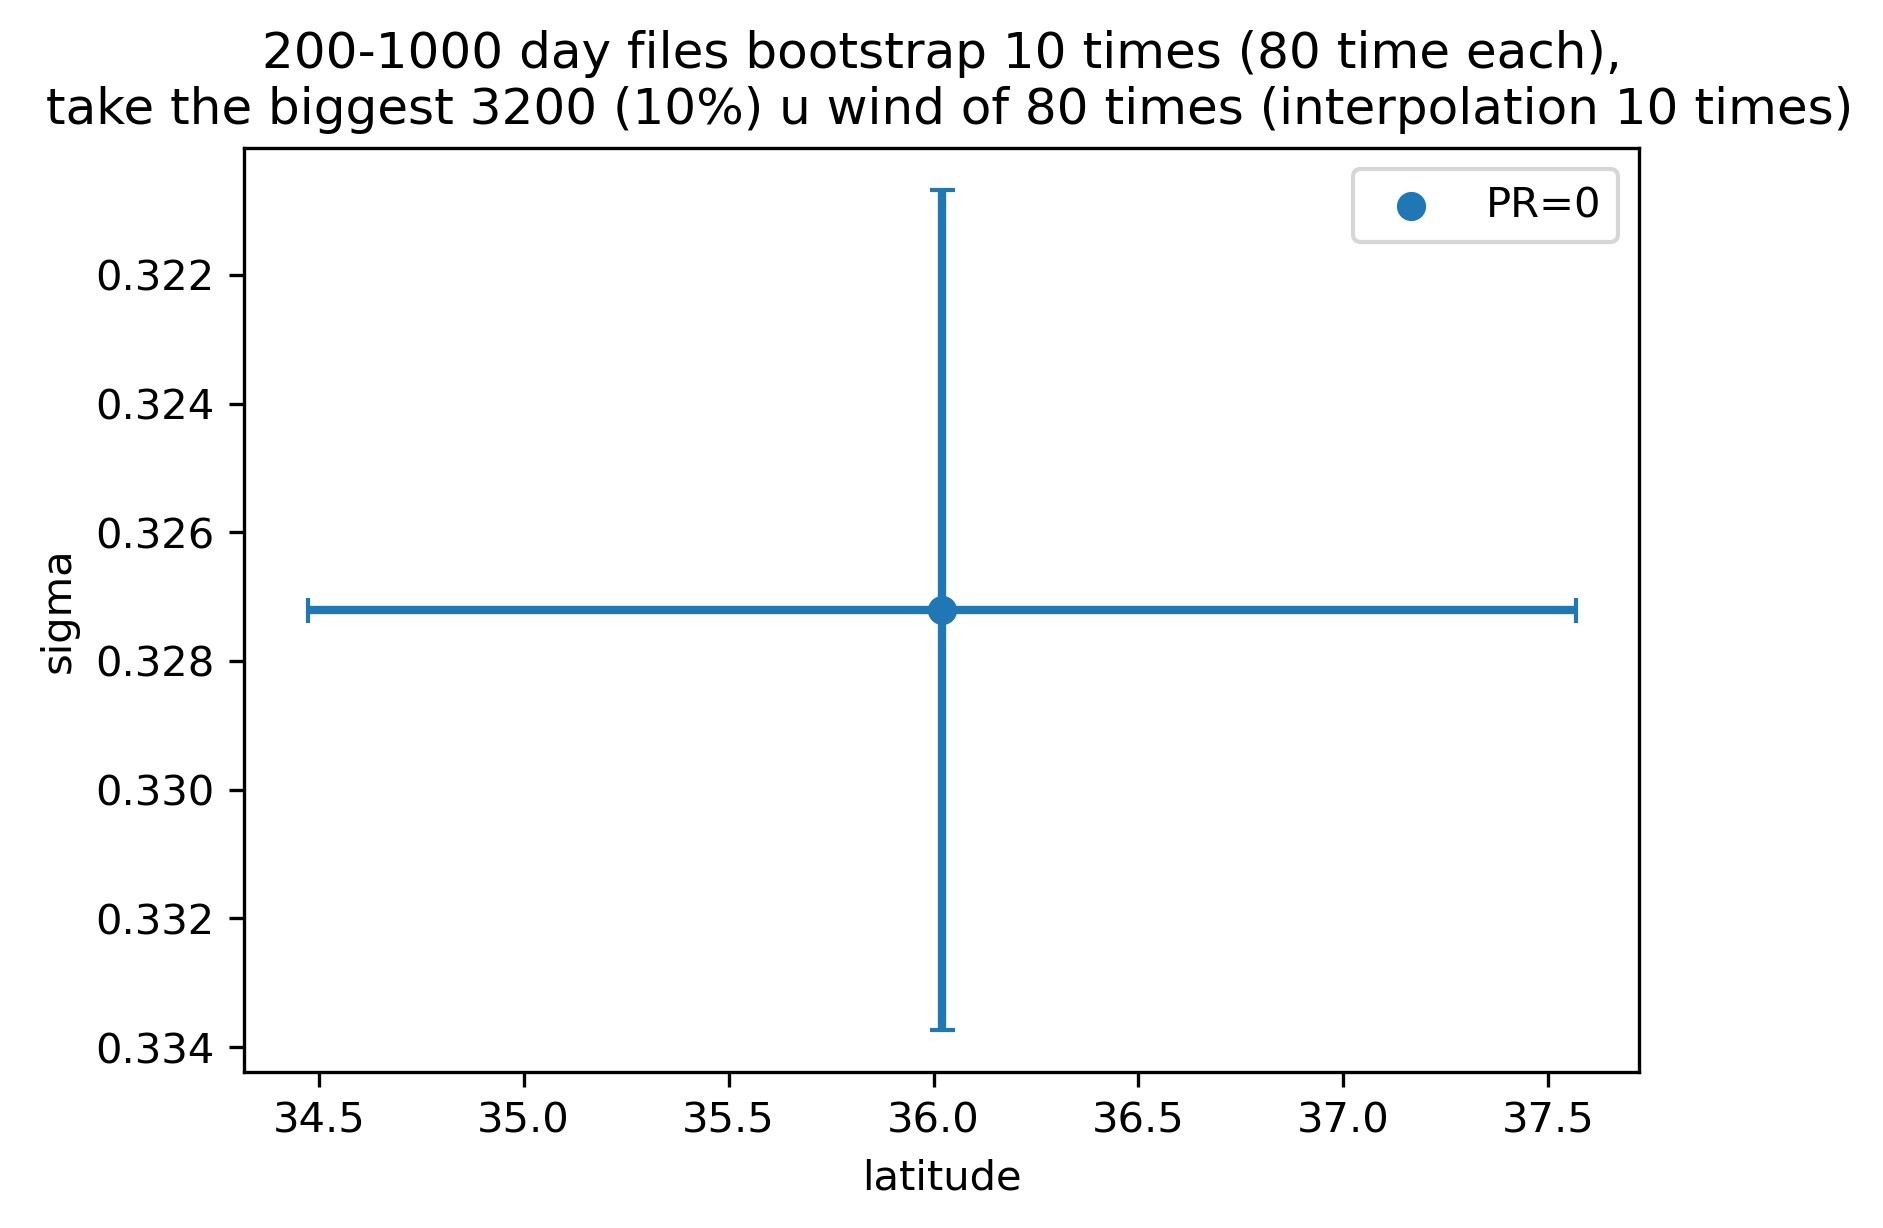

In [202]:
pr_start = 0
pr_leap = 5
pr_to = 40

### fig
# y = np.linspace(-90, 90, 64)
# yy, tt = np.meshgrid(y,time)
a      = int(0)
plt.figure(figsize=(6,4), dpi=300.)

#########

start = 200
end   = 1000
internal_day = 100
total_file = int((end - start) / internal_day)
print(total_file)
total_day = int(total_file*internal_day)

u = np.zeros((((800, 20, 64, 128))))

do_check_u_error_bar = True
a = 0
# b = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    # print(u_ini.shape)
    # b = 0
    for k in range(total_file):
        if do_check_u_error_bar:
            if k ==0:
                u[0:100,:,:,:]           = u_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]

    # Step 1. given value
    u_all_mean = np.nanmean(u, axis=(3)) # (800, 20, 32)

    # Step 2. Do interpolation, increasing resolution ten times
    interpolation_times = 1000
    yys           = np.linspace(0, 90, 32*interpolation_times)
    sigma_mean2s  = np.linspace(0,  1, 20*interpolation_times)
    
    # # Step 3. Do bootstrap
    total_time = 1000
    each_time = 80           # need to equal to the number of Fourier transform and wannt to see low frequency
    ### n denote to take the biggest n% in each day 
    n = 0.05
    
    selected_u_mean_z, selected_u_mean_y, CI_low_mean_z, CI_high_mean_z, CI_low_mean_y, CI_high_mean_y= bootstrap_y(u_all_mean[:,:,32:], total_time, each_time, n, interpolation_times, y , sigma_onlyz, yys, sigma_mean2s) # each_time need to eqaul to the amount of the number of Fourier transform

    
    y_error2  = CI_high_mean_y - np.nanmean(selected_u_mean_y)
    y_error   = np.nanmean(selected_u_mean_y) - CI_low_mean_y
    print(y_error, y_error2)

    z_error2  = CI_high_mean_z - np.nanmean(selected_u_mean_z)
    z_error   = np.nanmean(selected_u_mean_z) - CI_low_mean_z
    print(z_error, z_error2)
    
    print("PR:",f"{pr},\n z index:CI_high=",(CI_high_mean_z), "mean point=", np.nanmean(selected_u_mean_z),"CI_low=",(CI_low_mean_z))
    print("PR:",f"{pr},\n y index:CI_high=",(CI_high_mean_y), "mean point=", np.nanmean(selected_u_mean_y),"CI_low=",(CI_low_mean_y))
    ###########################################################
    print("===========================")
    print(f"PR={pr}:")
    print("y latitude:")
    
    print("CI high:", CI_high_mean_y)
    print("mean:   ", np.nanmean(selected_u_mean_y))
    print("CI low: ", CI_low_mean_y)
    print("===========================")
    print("z latitude:")
    print("CI high:", CI_high_mean_z)
    print("mean:   ", np.nanmean(selected_u_mean_z))
    print("CI low: ", CI_low_mean_z)
    print("===========================")
    ###############################################################
    plt.scatter( np.nanmean(selected_u_mean_y), np.nanmean(selected_u_mean_z), label=f"PR={pr}")
    plt.errorbar(np.nanmean(selected_u_mean_y), np.nanmean(selected_u_mean_z), xerr = np.stack([[y_error], [y_error2]]), yerr = np.stack([[z_error],[z_error2]]), fmt='o', elinewidth=2, capsize=3, ms=2) # 

    a += 1
plt.gca().invert_yaxis()
plt.title(f"200-1000 day files bootstrap {total_time} times ({each_time} time each),\n take the biggest {n} (10%) u wind of {each_time} times (interpolation {interpolation_times} times)")
plt.xlabel("latitude")
plt.ylabel("sigma")
plt.legend()
plt.savefig("check_u_index_bootstrap_2percentage.png", dpi=300, bbox_inches='tight')
plt.show()



                

In [ ]:
sigma_mean      = np.nanmean(p[-check_days_length:,:,:,:]/ps[-check_days_length:,:,:,:], axis=(0,3))
sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
y               = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)

plt.figure()
CS = plt.contourf(yy, sigma_mean2, np.nanmean(u,axis=(0,3)), levels=21)
plt.contour(yy, sigma_mean2, np.nanmean(u,axis=(0,3)), [34,36],colors= 'k')

plt.ylim([1,0])
plt.colorbar(CS)


In [ ]:
sigma_mean      = np.nanmean(p[-check_days_length:,:,:,:]/ps[-check_days_length:,:,:,:], axis=(0,3))
sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
y               = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)

u_new = np.mean(u, axis=(0,3))
print(20 * 64 * 0.1)
print(np.shape(u_new[0:2,32:38]))
u_new[0:10,32:44] = 0
plt.figure()
CS = plt.contourf(yy, sigma_mean2, u_new, levels=21)
plt.ylim([1,0])
plt.colorbar(CS)

In [ ]:
### 01/15 final work
### have done bootstrap function
### need to find the y index and z index using bootstrap method

# Reproduce Nick fig.1 using interpolative U

In [152]:
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline

In [153]:
y  = np.linspace(-90,90,64)
yd = np.deg2rad(y)
cy = np.cos(yd)

In [154]:
# PR=0
interpolation_times = 10
yys           = np.linspace(0, 90, 32*interpolation_times)
sigma_mean2s  = np.linspace(0,  1, 20*interpolation_times)
y_pr0 = 36.228926875979624
z_pr0 = 0.3238856163630653
print(np.shape(yys))

(320,)


In [155]:
z_biggest_all = np.zeros(8)
z_biggest_all[0] = 0.3238856163630653
z_biggest_all[1] = 0.32541720398869345
z_biggest_all[2] = 0.33223640625
z_biggest_all[3] = 0.3252315201005025
z_biggest_all[4] = 0.32447135364321605
z_biggest_all[5] = 0.3121236958228643
z_biggest_all[6] = 0.3052737688442211
z_biggest_all[7] = 0.2859219904208543




In [156]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [157]:
print(find_nearest(yys, value=y_pr0))
print(find_nearest(sigma_mean2s, value=z_pr0))


(36.1128526645768, 128)
(0.32160804020100503, 64)


800
PR: 0 ,maximum [z index, y index]: 64 128
Interpolation done
PR: 5 ,maximum [z index, y index]: 65 128
Interpolation done
PR: 10 ,maximum [z index, y index]: 66 128
Interpolation done
PR: 15 ,maximum [z index, y index]: 65 128
Interpolation done
PR: 20 ,maximum [z index, y index]: 65 128
Interpolation done
PR: 25 ,maximum [z index, y index]: 62 128
Interpolation done
PR: 30 ,maximum [z index, y index]: 61 128
Interpolation done
PR: 35 ,maximum [z index, y index]: 57 128
Interpolation done


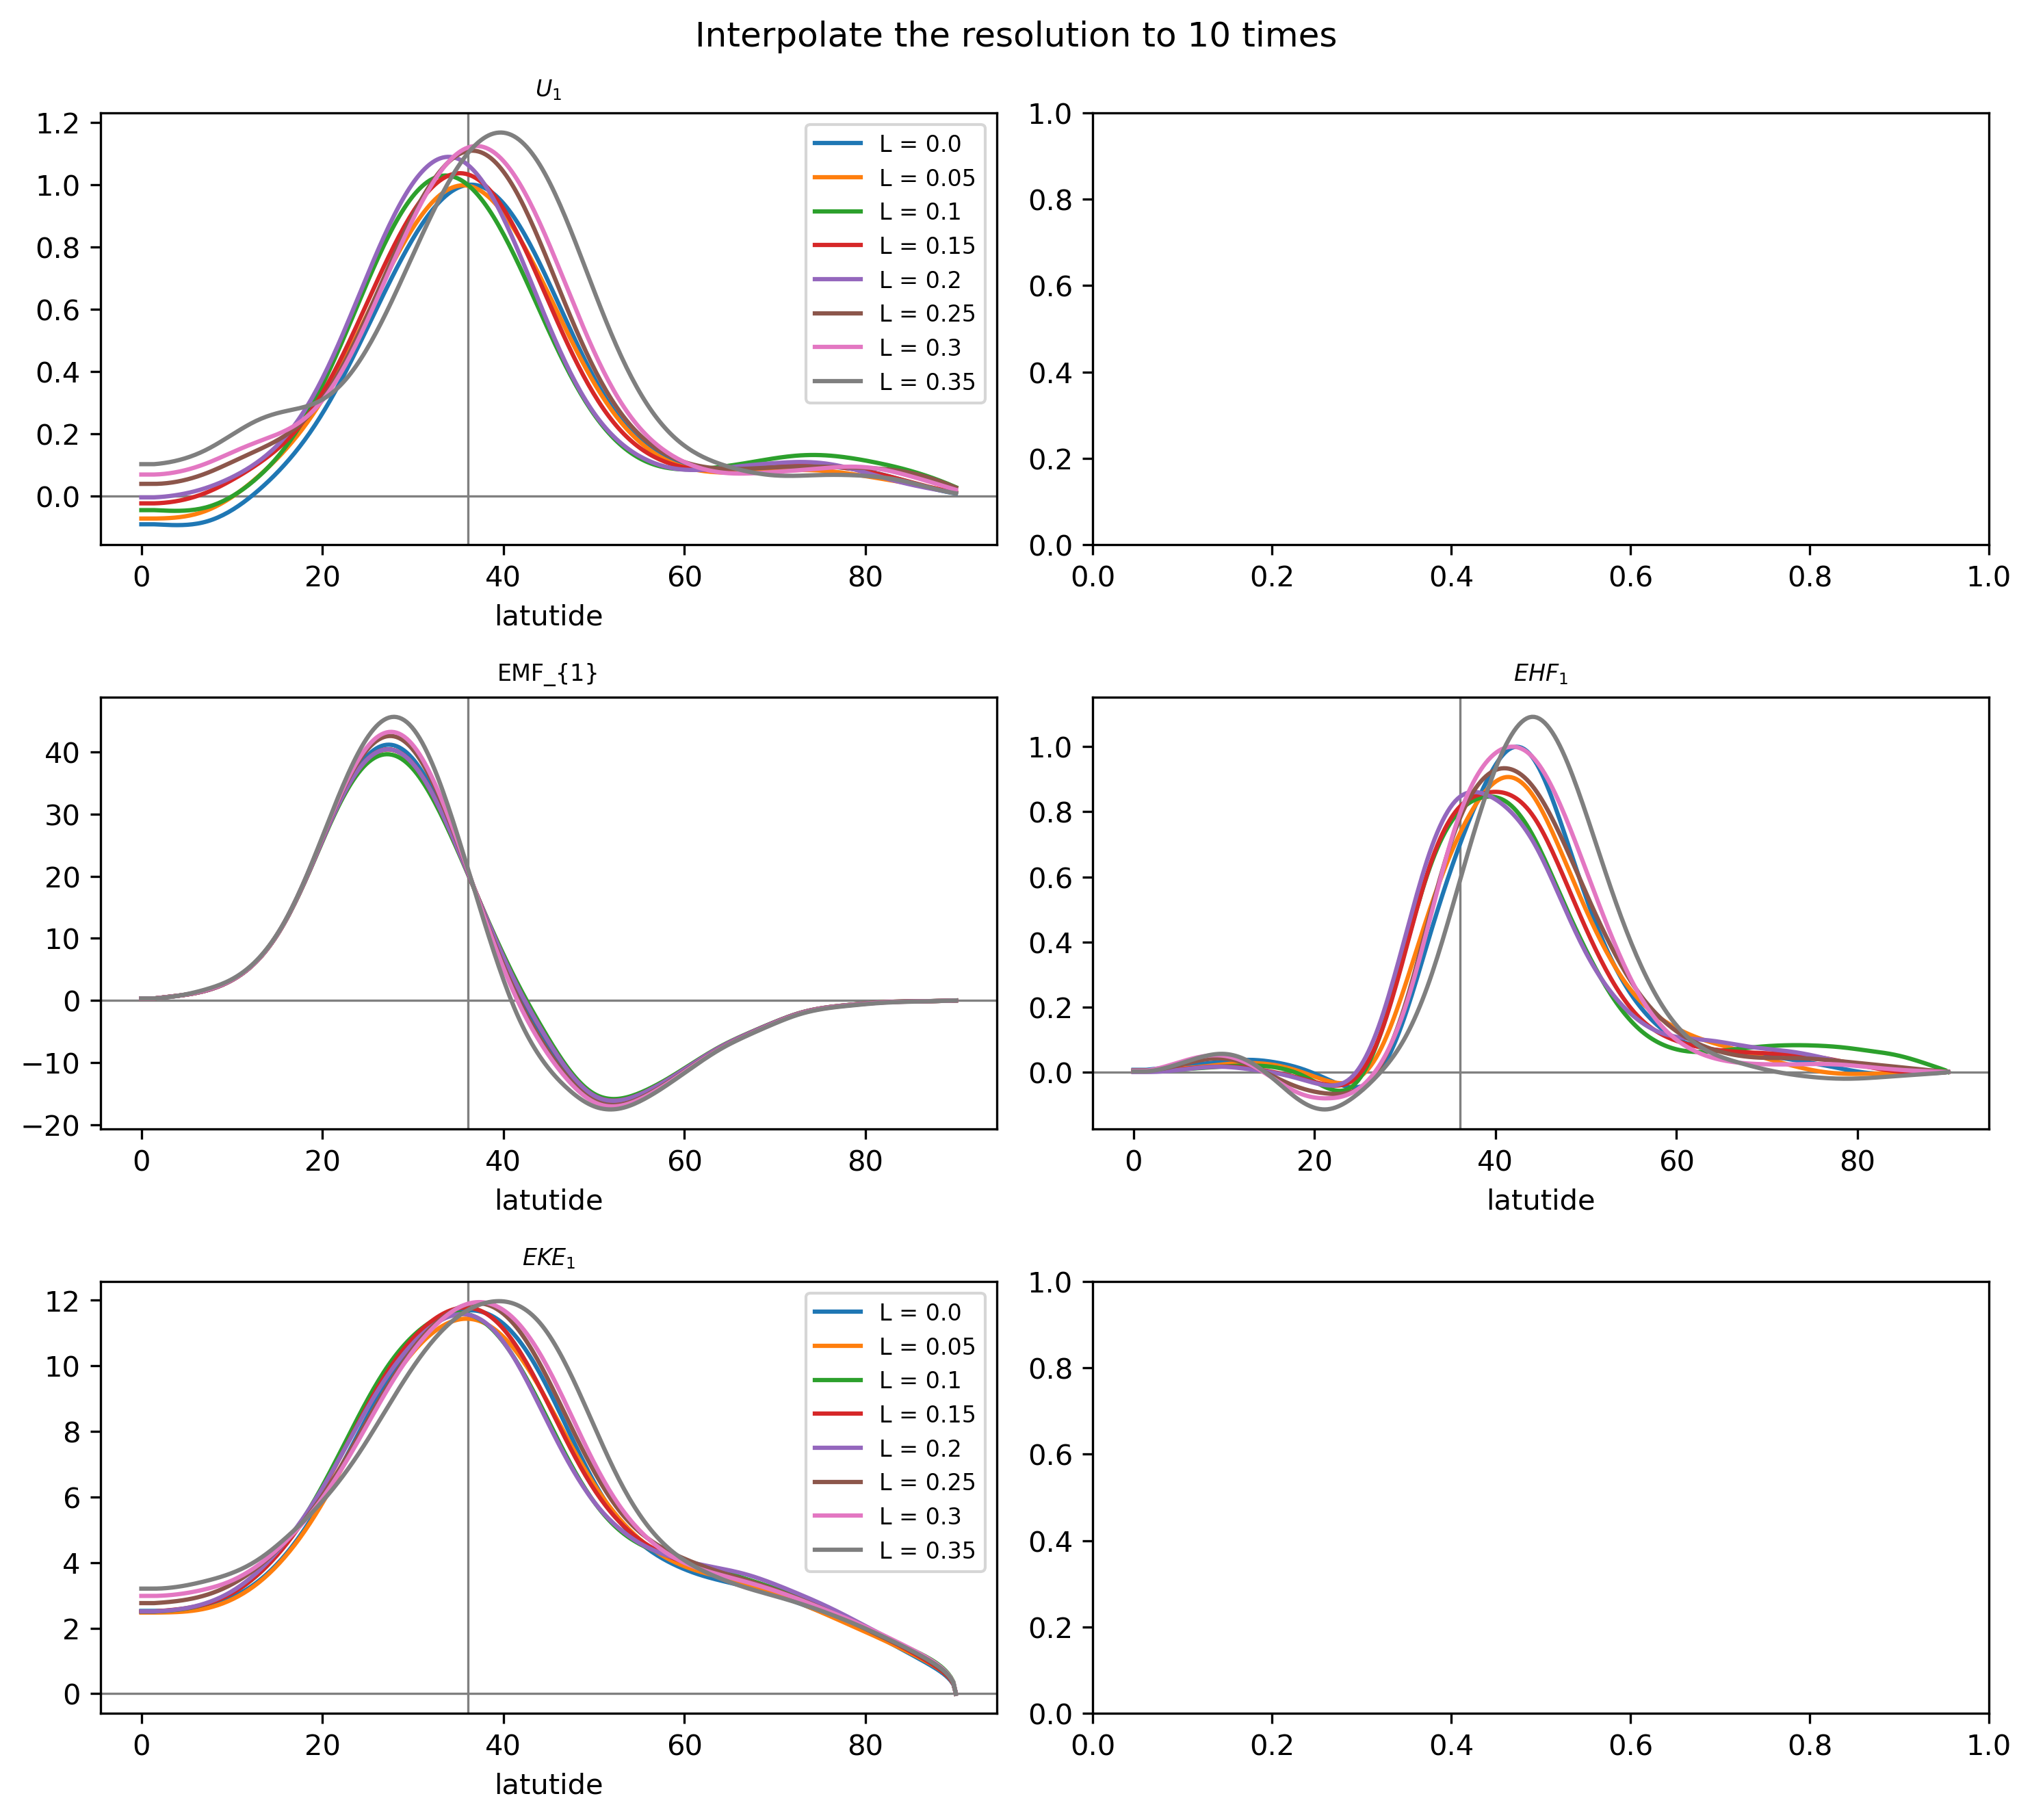

In [303]:
import matplotlib.colors as colors
import matplotlib as mpl

pr_start = 0
pr_leap = 5
pr_to = 40

start = 200
end   = 1000
internal_day = 100
total_file = int((end - start) / internal_day)
total_day = int(total_file*internal_day)
print(total_day)


u = np.zeros((((total_day, 20, 64, 128))))
v = np.zeros((((total_day, 20, 64, 128))))
p = np.zeros((((total_day, 20, 64, 128))))
ps = np.zeros((((total_day, 20, 64, 128))))
p_half = np.zeros((((total_day, 21, 64, 128))))
t = np.zeros((((total_day, 20, 64, 128))))


fig, ax = plt.subplots(3, 2, figsize=(10, 9), dpi=300.)
y = np.linspace(-90, 90, 64)
###
### for color
rgb=([112,115,115])
rgb=np.array(rgb)/255.0
icmap=colors.ListedColormap(rgb,name='my_color')
cmap=mpl.cm.viridis

cmap_color=icmap  
# bound=[1E-4,10E-4,25E-4,50e-4,100E-4,150E-4,200E-4,250e-4]
colors = np.array([[112,115,115],[182,203,227],[89,159,218],[0,83,170],[0,4,167],[0,140,1]])/255
########


do_check_biggest_n_U = True

pr_file = int((pr_to - pr_start) / pr_leap)
a = 0
pr_north_idx_z = []
pr_north_idx_y = []

# Find the biggest n u wind
n = 20
biggest_n_U_z = np.zeros((pr_file, n)) 
biggest_n_U_y = np.zeros((pr_file, n))
interpolation_times = 10

EMF_check = np.zeros(((pr_file, 20*interpolation_times, 32*interpolation_times)))
EHF_check = np.zeros(((pr_file, 20*interpolation_times, 32*interpolation_times)))
u_zy_thin_check = np.zeros(((pr_file, 20*interpolation_times, 32*interpolation_times)))

a = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if k ==0:
            u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
            v[0:100,:,:,:]             = v_ini[k,:,:,:,:]
            t[0:100,:,:,:]             = t_ini[k,:,:,:,:]
            p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
            ps[0:100,:,:,:]             = ps_ini[k,:,:,:,:]
            
        else:
            u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
            v[k*100:(k+1)*100,:,:,:] = v_ini[k,:,:,:,:]
            t[k*100:(k+1)*100,:,:,:] = t_ini[k,:,:,:,:]
            p[k*100:(k+1)*100,:,:,:] = p_ini[k,:,:,:,:]
            ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
    if pr == 0:
        if k ==0:
            p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
            ps[0:100,:,:,:]             = ps_ini[k,:,:,:,:]
        else:
            p[k*100:(k+1)*100,:,:,:] = p_ini[k,:,:,:,:]
            ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
            
        check_days_length = 800
        sigma_mean      = np.nanmean(p[-check_days_length:,:,:,:]/ps[-check_days_length:,:,:,:], axis=(0,3))
        sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
        y               = np.linspace(-90,90,64)
        yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)


    u_zy = np.nanmean(u, axis=(0,3))
    interpolation_times = 10
    u_zy_thin = np.zeros((20*interpolation_times, 32*interpolation_times))


    
    yys           = np.linspace(0, 90, 32*interpolation_times)
    sigma_mean2s  = np.linspace(0,  1, 20*interpolation_times)

    cyy = np.cos(np.deg2rad(yys))
    
    
    interp_spline          = RectBivariateSpline(sigma_onlyz, y[32:], u_zy[:,32:])
    u_zy_thin[:,:]         = interp_spline(sigma_mean2s, yys)
    u_zy_thin_check[a,:,:] = u_zy_thin

    biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
    biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/5)])
    
    print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)

    #########################################################################
    ## EMF
    u_prime        = np.rollaxis((np.rollaxis(u, 3, 0) - np.nanmean(u, axis=3)), 0, 4)
    v_prime        = np.rollaxis((np.rollaxis(v, 3, 0) - np.nanmean(v, axis=3)), 0, 4)
    Mzmtm      = np.nanmean(Uza * Vza, axis=(0,3))
    Mzmtm_thin = np.zeros((20*interpolation_times, 32*interpolation_times))
    
    interp_spline        = RectBivariateSpline(sigma_onlyz, y[32:], Mzmtm[:,32:])
    Mzmtm_thin[:,:]      = interp_spline(sigma_mean2s, yys)

    print("Interpolation done")
    
    Mzmtm_thin_w = np.zeros((20*interpolation_times, 32*interpolation_times))
    for i in range(20*interpolation_times):
        Mzmtm_thin_w[i,:] = Mzmtm_thin[i,:] * cyy[:]**0.5
    EMF_check[a,:,:] = Mzmtm_thin_w
    #########################################################################
    ## EKF
    # cal first, then interpolate.
    eddy_kinatic_energy    = 0.5 * np.nanmean((u_prime**2 + v_prime**2)**0.5, axis=(0,3))
    EKE_thin = np.zeros((20*interpolation_times, 32*interpolation_times))

    interp_spline      = RectBivariateSpline(sigma_onlyz, y[32:], eddy_kinatic_energy[:,32:])
    EKE_thin[:,:]      = interp_spline(sigma_mean2s, yys)

    EKE_thin_w = np.zeros((20*interpolation_times, 32*interpolation_times))
    for i in range(20*interpolation_times):
        EKE_thin_w[i,:] = EKE_thin[i,:] * cyy[:]**0.5
    ###
    # for i in range(800):
    #     for j in range(128):
    #     interp_spline      = RectBivariateSpline(sigma_onlyz, y[32:], eddy_kinatic_energy[:,32:])
    # EKE_thin[:,:]      = interp_spline(sigma_mean2s, yys)
    #########################################################################
    # EHF
    t_prime = np.rollaxis((np.rollaxis(t, 3, 0) - np.nanmean(t, axis=3)), 0, 4)
    b = t_prime / np.nanmean(t, axis=0) * 9.81
    eddy_flux_heat      = np.nanmean(b * v_prime, axis=(0, 3))
    eddy_flux_heat_thin = np.zeros((20*interpolation_times, 32*interpolation_times))

    interp_spline            = RectBivariateSpline(sigma_onlyz, y[32:], eddy_flux_heat[:,32:])
    eddy_flux_heat_thin[:,:] = interp_spline(sigma_mean2s, yys)
    eddy_flux_heat_thin_w = np.zeros((20*interpolation_times, 32*interpolation_times))
    for i in range(20*interpolation_times):
        eddy_flux_heat_thin_w[i,:] = eddy_flux_heat_thin[i,:] * cyy[:]**0.5
    EHF_check[a,:,:] = eddy_flux_heat_thin_w
    

    
    ### plot ###
    """
    # fig[0,0]
    """
    if pr == 0:
        # print("Northern Hemisphere")
        control = np.nanmax(u_zy_thin[biggest_u_z_idx,:])
        ax[0,0].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
        ax[0,0].axhline(y=0, color='gray', lw=0.8)
    
    ax[0,0].plot(yys, u_zy_thin[biggest_u_z_idx,:] / control, label=f"L = {pr/100}") #, color=colors[int(pr/5)]
    ax[0,0].set_title("$U_{1}$", fontsize=8)
    ax[0,0].set_xlabel("latutide")
    """
    # fig[1,0]
    """
    if pr == 0:
        # print("Northern Hemisphere")
        EMF_control = np.nanmax(Mzmtm_thin_w[biggest_u_z_idx,:])
        ax[1,0].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
        ax[1,0].axhline(y=0, color='gray', lw=0.8)

    ax[1,0].plot(yys, Mzmtm_thin_w[biggest_u_z_idx,:], label=f"L = {pr/100}")
    ax[1,0].set_title("EMF_{1}", fontsize=8)
    ax[1,0].set_xlabel("latutide")
    """
    # fig[2,0]
    """
    if pr == 0:
        # print("Northern Hemisphere")
        EKE_control = np.nanmax(EKE_thin_w[biggest_u_z_idx,:])
        ax[2,0].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
        ax[2,0].axhline(y=0, color='gray', lw=0.8)
        
    ax[2,0].plot(yys, EKE_thin_w[biggest_u_z_idx,:], label=f"L = {pr/100}")
    ax[2,0].set_title("$EKE_{1}$", fontsize=8)
    ax[2,0].set_xlabel("latutide")
    """
    # fig[1,1]
    """
    if pr == 0:
        # print("Northern Hemisphere")
        EHF_control = np.nanmax(eddy_flux_heat_thin_w[biggest_u_z_idx-25,:])
        ax[1,1].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
        ax[1,1].axhline(y=0, color='gray', lw=0.8)
        
    ax[1,1].plot(yys, eddy_flux_heat_thin_w[biggest_u_z_idx-25,:] / EHF_control, label=f"L = {pr/100}")
    ax[1,1].set_title("$EHF_{1}$", fontsize=8)
    ax[1,1].set_xlabel("latutide")
    

    a += 1
ax[0,0].legend()
ax[2,0].legend()

ax[0,0].legend(prop={'size': 8})
ax[2,0].legend(prop={'size': 8})

plt.suptitle(f"Interpolate the resolution to {interpolation_times} times")

fig.tight_layout()
plt.show()

PR: 0 ,maximum [z index, y index]: 64 128
PR: 5 ,maximum [z index, y index]: 65 128
PR: 10 ,maximum [z index, y index]: 66 128
PR: 15 ,maximum [z index, y index]: 65 128
PR: 20 ,maximum [z index, y index]: 65 128
PR: 25 ,maximum [z index, y index]: 62 128
PR: 30 ,maximum [z index, y index]: 61 128
PR: 35 ,maximum [z index, y index]: 57 128


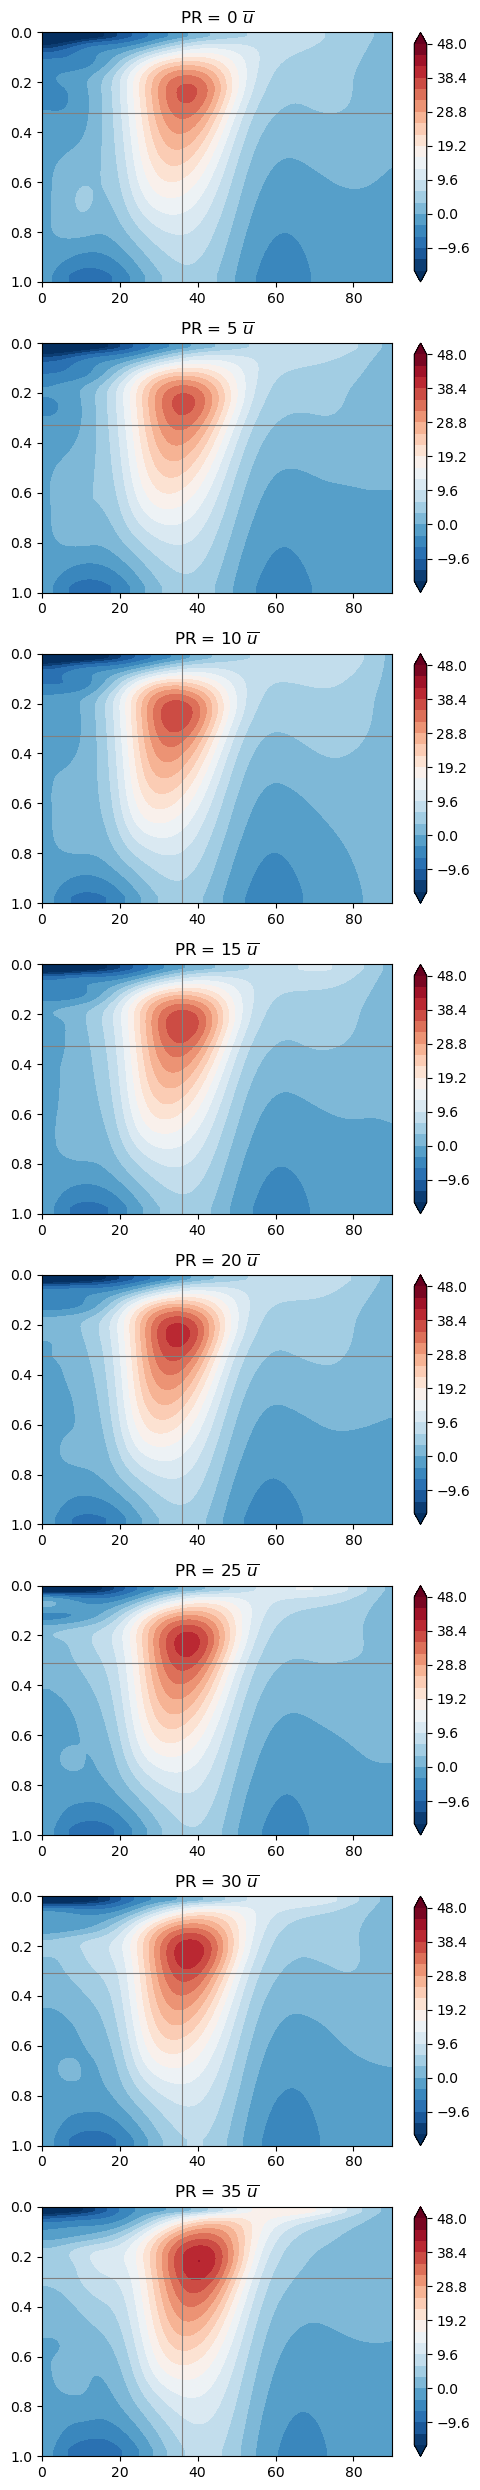

In [305]:
fig, ax = plt.subplots(8, figsize=(5,25), dpi=100.)
for i in range(8):
    pr = i*5
    biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
    biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/5)])
    print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)
    CS = ax[i].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], u_zy_thin_check[i,:,:], levels=np.linspace(-16,48,21), cmap="RdBu_r", extend="both")
    plt.colorbar(CS, ax=ax[i])
    ax[i].set_ylim([1,0])
    ax[i].set_title(f"PR = {pr}"+" $\overline{u}$")
    ax[i].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
    ax[i].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
plt.tight_layout()
plt.show()


PR: 0 ,maximum [z index, y index]: 64 128
PR: 5 ,maximum [z index, y index]: 65 128
PR: 10 ,maximum [z index, y index]: 66 128
PR: 15 ,maximum [z index, y index]: 65 128
PR: 20 ,maximum [z index, y index]: 65 128
PR: 25 ,maximum [z index, y index]: 62 128
PR: 30 ,maximum [z index, y index]: 61 128
PR: 35 ,maximum [z index, y index]: 57 128


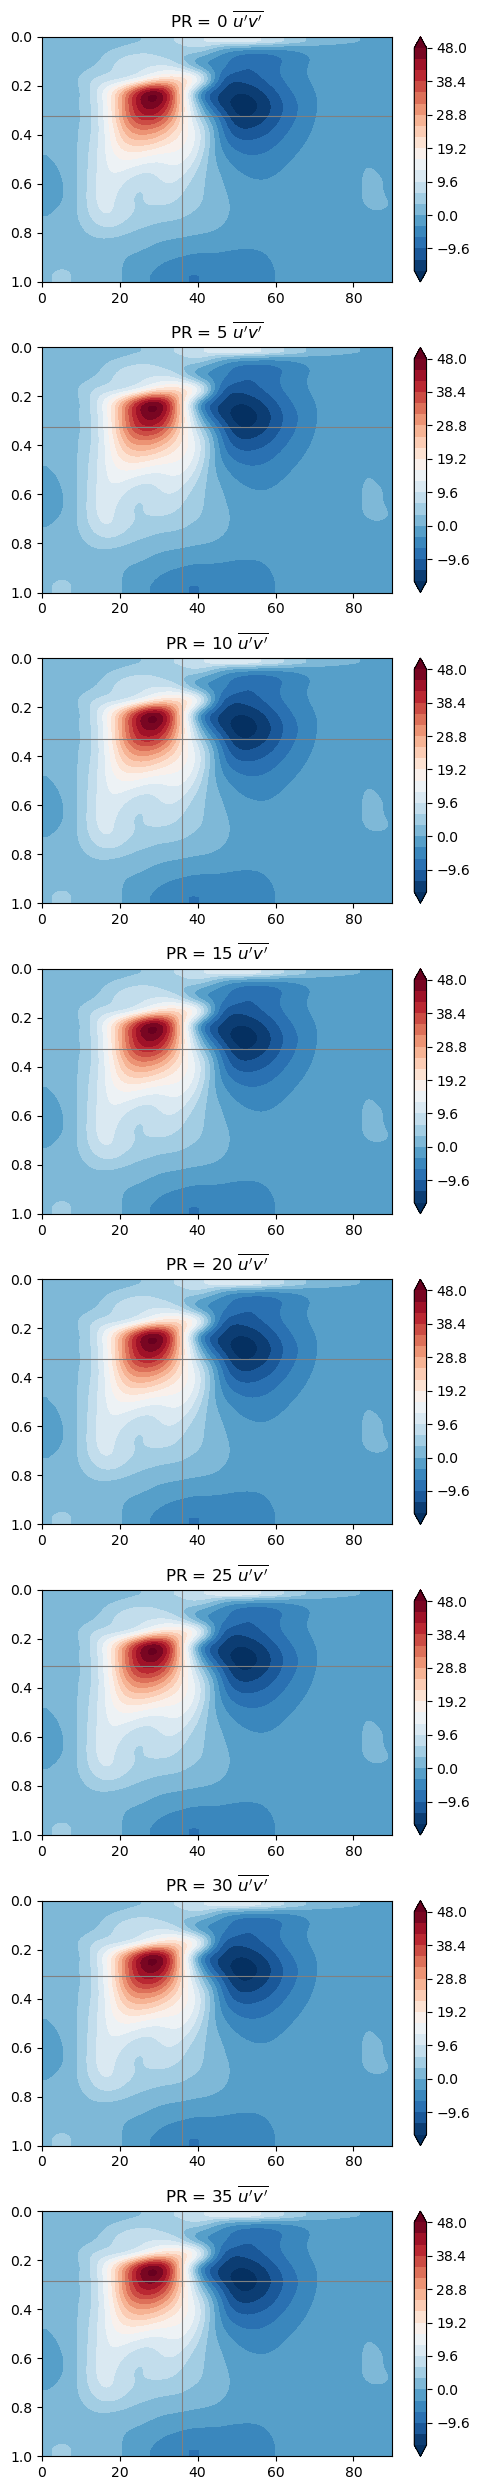

In [301]:
fig, ax = plt.subplots(8, figsize=(5,25), dpi=100.)
for i in range(8):
    pr = i*5
    biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
    biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/5)])
    print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)
    CS = ax[i].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], EMF_check[i,:,:], levels=np.linspace(-16,48,21), cmap="RdBu_r", extend="both")
    plt.colorbar(CS, ax=ax[i])
    ax[i].set_ylim([1,0])
    ax[i].set_title(f"PR = {pr}"+" $\overline{u'v'}$")
    ax[i].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
    ax[i].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
plt.tight_layout()
plt.show()


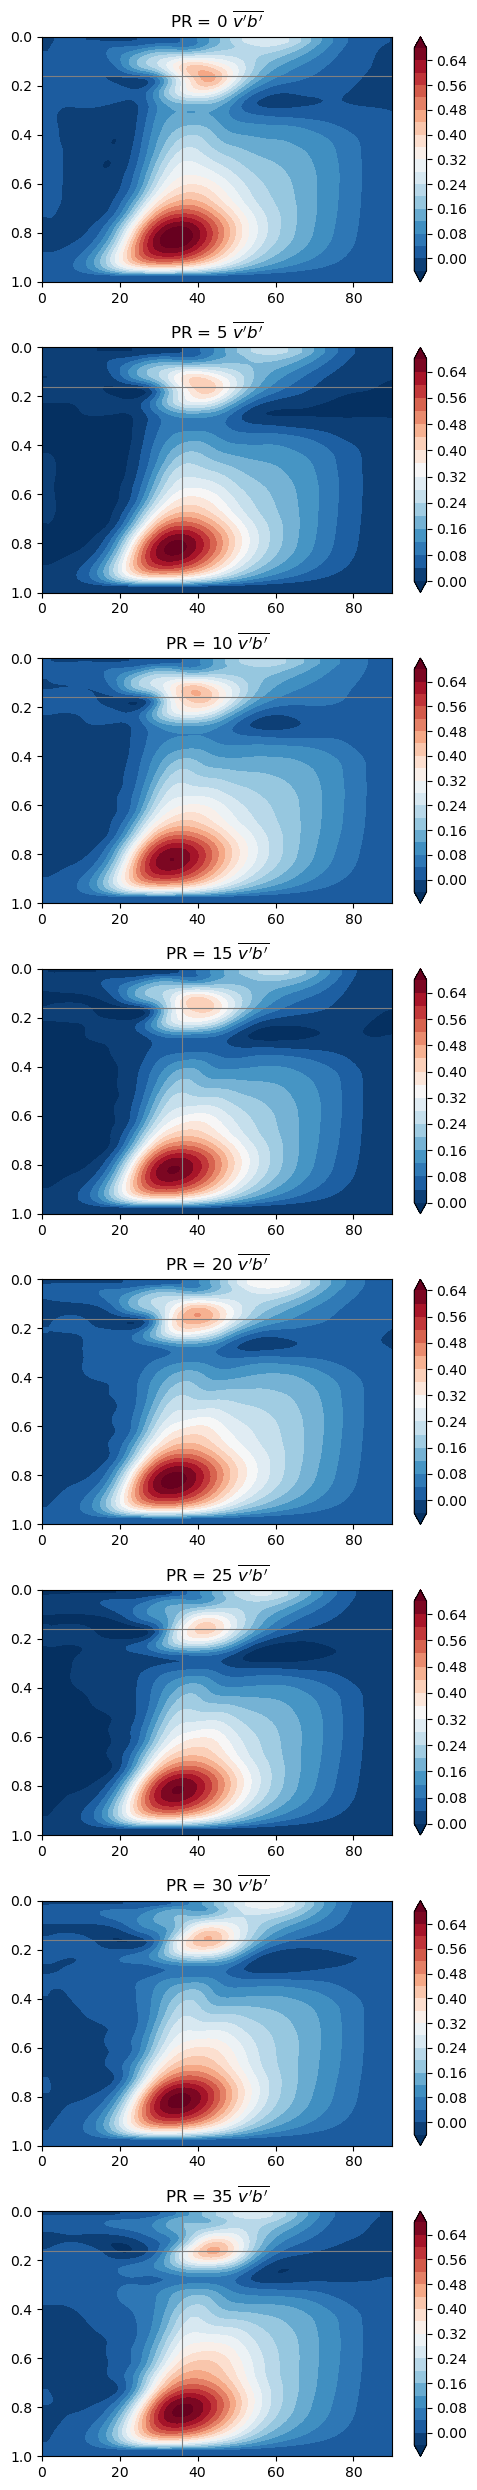

In [296]:
fig, ax = plt.subplots(8, figsize=(5,25), dpi=100.)
for i in range(8):
    pr = i*5
    CS = ax[i].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], EHF_check[i,:,:], levels=21, cmap="RdBu_r", extend="both")
    plt.colorbar(CS, ax=ax[i])
    ax[i].set_ylim([1,0])
    ax[i].set_title(f"PR = {pr}"+" $\overline{v'b'}$")
    ax[i].axhline(y=sigma_mean2s[biggest_u_z_idx-25], color='gray', lw=0.8)
    ax[i].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
plt.tight_layout()
plt.show()

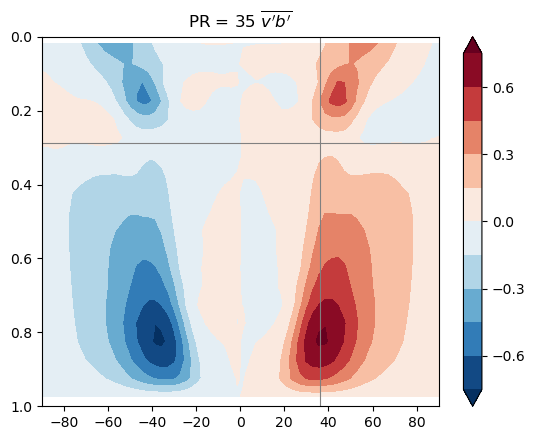

In [206]:
vb = np.nanmean(b * v_prime, axis=(0,3))
plt.figure()
CS = plt.contourf(yy[:,:], sigma_mean2[:,:], vb, levels=11, cmap="RdBu_r", extend="both")
plt.colorbar(CS)
plt.ylim([1,0])
plt.title("PR = 35 $\overline{v'b'}$")
plt.axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
plt.axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)


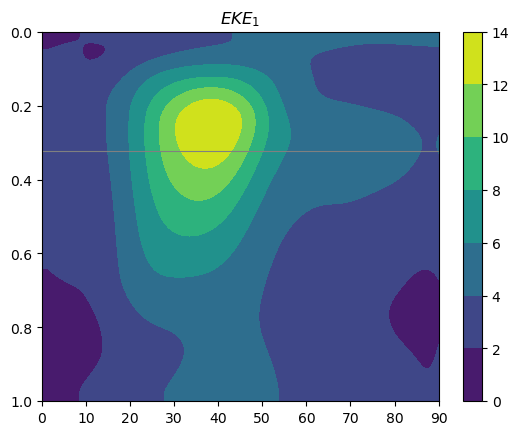

In [183]:
plt.figure()
CS = plt.contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], EKE_thin)
plt.colorbar(CS)
plt.ylim([1,0])
plt.title("$EKE_{1}$")
plt.axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)


In [193]:
sigma_mean2s[biggest_u_z_idx]

0.32160804020100503

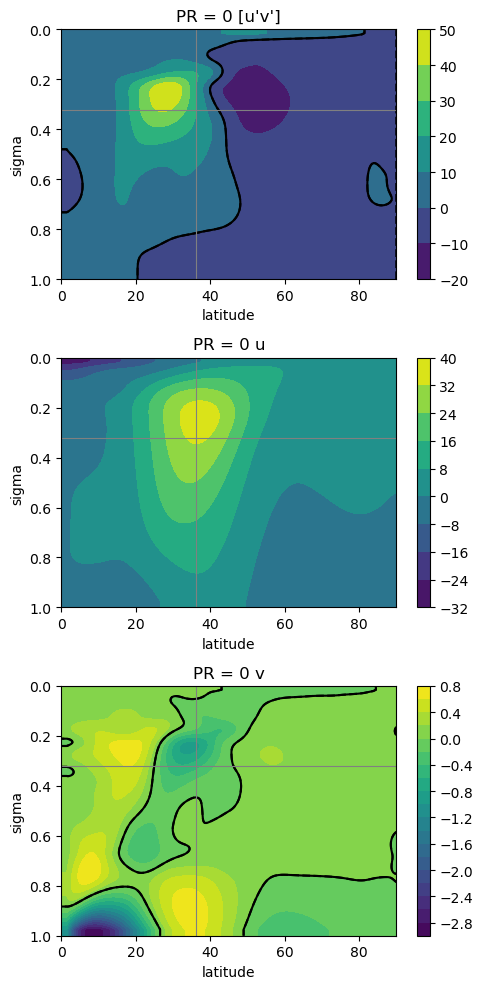

In [195]:
yys_2d, sigma_mean2s_2d = np.meshgrid(yys, sigma_mean2s)
fig, ax = plt.subplots(3, figsize=(5, 10), dpi=100.)

CS = ax[0].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], Mzmtm_thin_w)
ax[0].contour(yys_2d[:,:], sigma_mean2s_2d[:,:], Mzmtm_thin_w, [-0.00000001, 0.], colors='k')
plt.colorbar(CS, ax=ax[0])
ax[0].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
ax[0].axhline(y=0, color='gray', lw=0.8)
ax[0].set_ylim([1,0])
ax[0].set_title("PR = 0 [u'v']")
ax[0].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)



CS = ax[1].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], u_thin_zy)

plt.colorbar(CS, ax=ax[1])

ax[1].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
ax[1].axhline(y=0, color='gray', lw=0.8)
ax[1].set_ylim([1,0])
ax[1].set_title("PR = 0 u")
ax[1].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)


# plt.figure()
CS = ax[2].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], v_thin_zy, levels=21)
ax[2].contour(yys_2d[:,:], sigma_mean2s_2d[:,:], v_thin_zy, [-0.00000001, 0.], colors='k')
plt.colorbar(CS, ax=ax[2])
ax[2].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
ax[2].axhline(y=0, color='gray', lw=0.8)
ax[2].set_ylim([1,0])
ax[2].set_title("PR = 0 v")
ax[2].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)

for i in range(3):
    ax[i].set_xlabel("latitude")
    ax[i].set_ylabel("sigma")
plt.tight_layout()
plt.show()

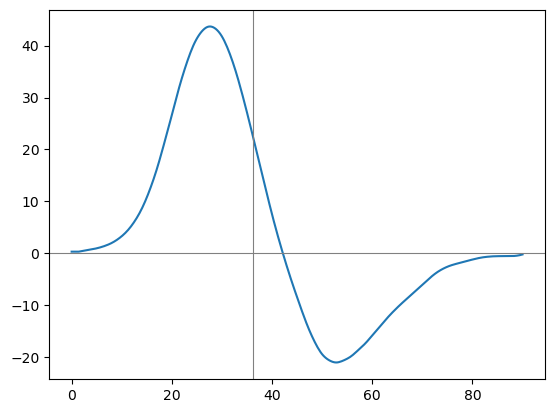

In [66]:
plt.figure()
plt.plot(yys, Mzmtm[biggest_u_z_idx,:])
plt.axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
plt.axhline(y=0, color='gray', lw=0.8)

In [173]:
dmdy = np.zeros((20*interpolation_times,32*interpolation_times))
r = 6371e3
for i in range(1,32*interpolation_times-1):
    dmdy[:,i] = -(Mzmtm[:,i+1] - Mzmtm[:,i-1]) / (r * (yys[i+1] - yys[i-1]))
dmdy[:, 0] = -(Mzmtm[:, 1] - Mzmtm[:, 0]) / (r*(yys[ 1] - yys[ 0]))
dmdy[:,-1] = -(Mzmtm[:,-1] - Mzmtm[:,-2]) / (r*(yys[-1] - yys[-2]))

(1.0, 0.0)

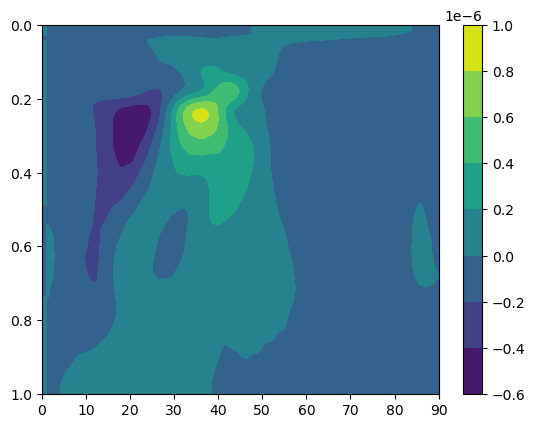

In [174]:
plt.figure()
CS = plt.contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], dmdy)
plt.colorbar(CS)
plt.ylim([1,0])

5.6426332288401255
41.755485893416925
36.1128526645768
43.68307859053075


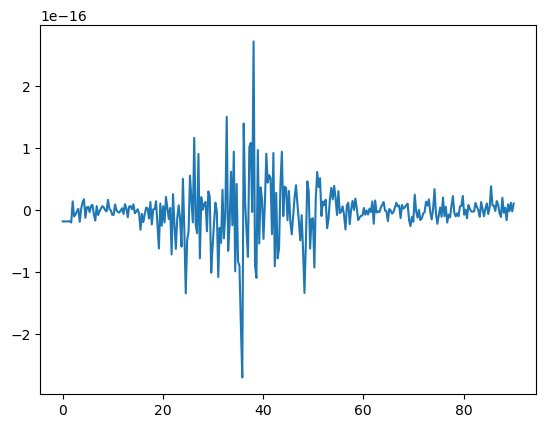

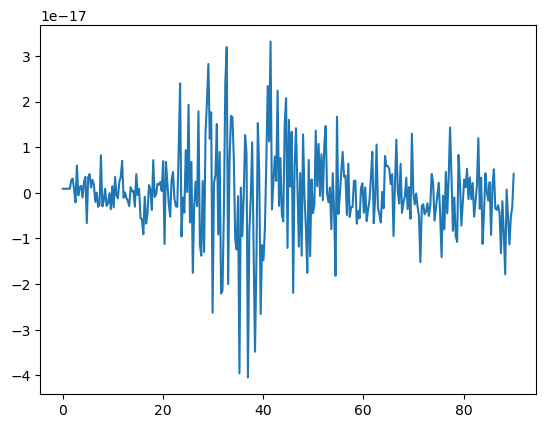

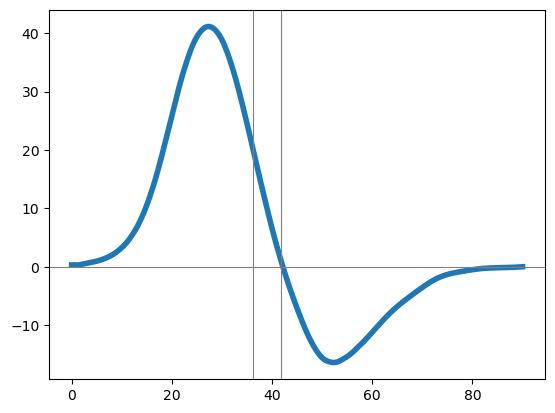

In [24]:
plt.figure()
plt.plot(yys, np.nanmean(Uza_w[:,biggest_u_z_idx,:,:],axis=(0,2)))
plt.figure()
plt.plot(yys, np.nanmean(Vza_w[:,biggest_u_z_idx,:,:],axis=(0,2)))
plt.figure()
plt.plot(yys, np.nanmean(Uza_w[:,biggest_u_z_idx,:,:]* Vza_w[:,biggest_u_z_idx,:,:],axis=(0,2))* cyy[:]**0.5, lw=4)
# plt.plot(yys, np.nanmean(Uza_w[:,:,:,:]* Vza_w[:,:,:,:],axis=(0,2))* cyy[:]**0.5/ EMF_control * 0.05, lw=4)

plt.axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
plt.axvline(x=yys[biggest_u_y_idx+20], color='gray', lw=0.8)

plt.axhline(y=0, color='gray', lw=0.8)
print(yys[biggest_u_y_idx+20] - yys[biggest_u_y_idx])
print(yys[biggest_u_y_idx+20])
print(yys[biggest_u_y_idx])
print(np.max(np.nanmean(Uza_w[:,biggest_u_z_idx,:,:]* Vza_w[:,biggest_u_z_idx,:,:],axis=(0,2))))


TypeError: Shapes of x (200, 320) and z (300, 480) do not match

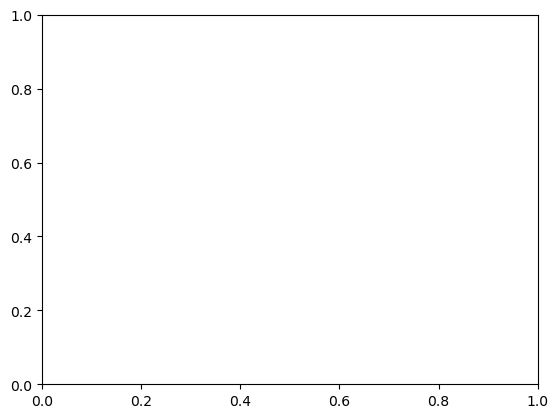

In [78]:
plt.figure()
CS = plt.contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], np.nanmean(V_thin, axis=(0,3)), levels=21)
plt.contour(yys_2d[:,:], sigma_mean2s_2d[:,:], np.nanmean(V_thin, axis=(0,3)), [0., 0.0001])

plt.ylim([1,0])

38.571428571428584


(1.0, 0.0)

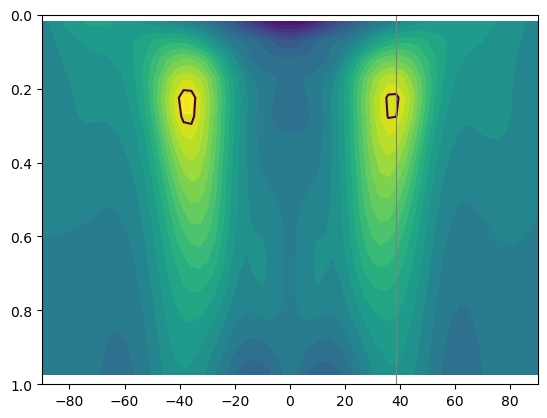

In [42]:
plt.figure()
plt.contourf(yy, sigma_mean2, np.nanmean(u, axis=(0,3)), levels=21)
plt.contour(yy, sigma_mean2, np.nanmean(u, axis=(0,3)), [35,36])
plt.axvline(x=y[45], color='gray', lw=0.8)
print(y[45])
plt.ylim([1,0])


(200,)
(200, 320)


(1.0, 0.0)

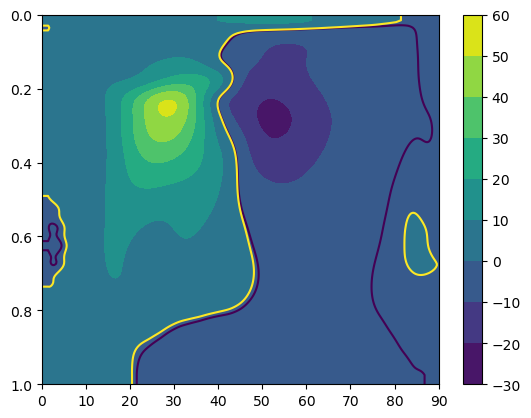

In [28]:
print(np.shape(sigma_mean2s))
yys_2d, sigma_mean2s_2d = np.meshgrid(yys, sigma_mean2s)
print(np.shape(yys_2d))
plt.figure()
CS = plt.contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], np.nanmean(M, axis=(0,3)))
plt.contour(yys_2d[:,:], sigma_mean2s_2d[:,:], np.nanmean(M, axis=(0,3)), [-0.5,0])

plt.colorbar(CS)
plt.ylim([1,0])

In [27]:
eddy_u_zy_thin[biggest_u_z_idx,:] = u_zy_thin[biggest_u_z_idx,:] - np.nanmean(u_zy_thin[biggest_u_z_idx,:])
eddy_v_zy_thin[biggest_v_z_idx,:] = v_zy_thin[biggest_v_z_idx,:] - np.nanmean(v_zy_thin[biggest_v_z_idx,:])


NameError: name 'eddy_u_zy_thin' is not defined

In [ ]:
eddy_u_zy_thin[biggest_u_z_idx,:] = u_zy_thin[biggest_u_z_idx,:] - np.nanmean(u_zy_thin[biggest_u_z_idx,:])
eddy_v_zy_thin[biggest_v_z_idx,:] = v_zy_thin[biggest_v_z_idx,:] - np.nanmean(v_zy_thin[:,:])

In [ ]:
np.max(v_zy_thin[:,:])

In [ ]:
plt.figure()
plt.plot(yys, (eddy_u_zy_thin[biggest_v_z_idx,:]) / control, label=f"L = {pr/100}")
plt.figure()
plt.plot(yys, (eddy_v_zy_thin[biggest_v_z_idx,:]) , label=f"L = {pr/100}")

In [ ]:
plt.figure()
plt.plot(yys, (eddy_u_zy_thin[biggest_u_z_idx,:]/ control*eddy_v_zy_thin[biggest_v_z_idx,:]) , label=f"L = {pr/100}")

In [ ]:
print(np.shape(v))

In [ ]:
v_mean = np.nanmean(v, axis=(0,3))
u_mean = np.nanmean(u, axis=(0,3))

u_test = u_mean - np.nanmean(u_mean)
v_test = v_mean - np.nanmean(v_mean)



In [ ]:
np.nanmean(u_mean)

In [ ]:
plt.figure()
CS = plt.contourf(yy, sigma_mean2, v_test)
plt.colorbar(CS)
plt.ylim([1,0])

In [ ]:
plt.figure()
CS = plt.contourf(yy, sigma_mean2, u_test)
plt.colorbar(CS)
plt.ylim([1,0])

In [ ]:
plt.figure()
CS = plt.contourf(yy, sigma_mean2, u_mean * v_mean)
plt.colorbar(CS)
plt.ylim([1,0])